# **Predicting Salary From H1B Database**
By Mengdie Hu, Shuo Sun, Ziyu Wang

# **Catalog**
 


*   Task & Motivation
*   Dataset
*   Import
*   Data Loading
*   Data Wrangling
*   EDA
*   Feature Engineering
*   Model
*   Interactive Demo
*   Summary



## **Task & Motivation**
---------

H1B visa is a nonimmigrant work visa that allows US employers to hire highly educated foreign professionals(at least a bachelor degree’s or the equivalent) in the specialty occupation, especially in the field of IT, finance, engineering, etc. However, it’s not easy to obtain H1B visas as there are many requirements that both employers and employees need to fulfill, also every year USCIS approves around 200,000 H1B petitions but only 65,000 are granted visas through the lottery. One of the main requirements for an H1B visa is that the employer guarantees to pay the H1B holders **prevailing wage** which means the average salary paid to similarly qualified workers in the same geographical area. So the salary is definitely a very crucial component in successfully obtaining an H1B visa. 

In this project, we would like to use the H1B Disclosure Data from 2022 to explore the relationship between salary and other key factors like geography, job title, job level, company name, etc. The main objective of this project is to accurately predict foreigners’ salaries using regression methods like linear regression, linear regression with regularization, decision trees, K Nearest Neighbors and Neural Networks. We would like to build an ML model that can serve as an useful tool for international students who would like to build their career path by outputting an accurate salary when they input their job title, state, city, company, etc.


## **Dataset**
---------

Our dataset comes from the data disclosed by the Office of Foreign Labor Certification (OFLC).(https://www.dol.gov/agencies/eta/foreign-labor/performance#dis) The dataset is cumulative for the fiscal year, containing 95 columns.( For explanations of the data columns see https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/LCA_Record_Layout_FY2022_Q4.pdf). Most of this features are of little use to us or have a large number of `NAN` values, such as Employer Contact address information, Employer website infromation, etc. So we first manually dimensionalize the data. In order to have a quick understanding of the dataset, we have prioritized more than twenty features that are highly correlated with wages.

#### Download Dataset



(If on Colab, skip this) Run (MacOS/Linux)

```shell
chmod a+x download.sh
./download.sh
```

## **Import**
-------

Mount shareddrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import os
import time
import glob
import nltk
import gensim
import gensim.downloader
import torch
import torchvision

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import ipywidgets as widgets

from math import sqrt
from datetime import date
from IPython.display import display
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from fuzzywuzzy import fuzz
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

#import sklearn packages
from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **Data Loading**
_____

#### (If on Colab, skip this) Combine quarterly data into yearly data

The original dataset from OFLC came in Excel format and has 4 datasets for 2022. We convert the Excel files to CSV files since pandas read csv much faster and also combines the quarterly data into the yearly data. This would takes approximately one hour to run, so we saved the csv files for furthur usage.

In [ ]:
years = ['2017', '2018', '2019', '2020', '2021', '2022']

print('Combining and Transforming excel file to csv')
for year in years:
    print(f'Starting Year {year}')
    file_list = glob.glob('data/' + year + '/*.xlsx')
    excel_list=[]
    num = len(file_list)
    for i in range(num):
        print(f'Reading File {i+1} / {num}')
        excel_list.append(pd.read_excel(file_list[i]))
    year_df = pd.DataFrame()
    for i in range(num):
        print(f'Combining File {i+1} / {num}')
        year_df = year_df.append(excel_list[i], ignore_index = True)
    print('Transforming File')
    year_df.to_csv ('data/' + year + '/raw.csv', index = None, header=True)
    print(f'File for Year {year} saved')

##### We can safely delete Excel files since we do not need them anymore

Run (MacOS/Linux)
```
chmod a+x delete.sh
./delete.sh
```

#### Load .csv File

We directly run the 2022 csv files that was saved from above for efficiency.

In [ ]:
df2022_raw = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/raw.csv')

### **H1B Disclosure Data 2022**

In [ ]:
df2022_raw

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_CODE,SOC_TITLE,FULL_TIME_POSITION,...,WILLFUL_VIOLATOR,SUPPORT_H1B,STATUTORY_BASIS,APPENDIX_A_ATTACHED,PUBLIC_DISCLOSURE,PREPARER_LAST_NAME,PREPARER_FIRST_NAME,PREPARER_MIDDLE_INITIAL,PREPARER_BUSINESS_NAME,PREPARER_EMAIL
0,I-200-21270-606997,Certified,2021-09-26,2021-10-01,NaN,H-1B,APPLICATIONS SUPPORT ANALYST/ADMINISTRATOR,15-1132.00,"Software Developers, Applications",Y,...,No,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
1,I-200-21270-606867,Certified,2021-09-26,2021-10-01,NaN,H-1B,Designer,17-3013.00,Mechanical Drafters,Y,...,No,NaN,NaN,NaN,Disclose Business and Employment,Stacey,Francyne,NaN,Stacey Law Practice,francyne@staceylawpractice.com
2,I-200-21270-606846,Certified,2021-09-26,2021-10-01,NaN,H-1B,Data Analyst,15-2031.00,Operations Research Analysts,Y,...,No,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
3,I-200-21270-606842,Certified,2021-09-26,2021-10-01,NaN,H-1B,Pharmaceutical Chemist,19-2031.00,Chemists,Y,...,No,NaN,NaN,NaN,Disclose Business,JONNALAGADDA,SRINIVASA,R,"S. R. JONNALAGADDA, P.C.",Lawassociates@att.net
4,I-200-21270-606941,Certified,2021-09-26,2021-10-01,NaN,H-1B,Senior Systems Analyst JC60,15-1121.00,Computer Systems Analysts,Y,...,No,Yes,"$60,000 or higher annual wage",NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626079,I-200-22087-013909,Withdrawn,2022-03-28,2022-03-31,NaN,H-1B,"Senior Backend Software Engineer, Instruments",15-1132.00,"Software Developers, Applications",Y,...,No,NaN,NaN,NaN,Disclose Employment,Wright,Christopher,M,"The Wright Law Firm, APC",eva@thewrightlawfirm.com
626080,I-203-22087-015385,Withdrawn,2022-03-28,2022-03-31,NaN,E-3 Australian,Coach,27-2022.00,Coaches and Scouts,Y,...,NaN,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
626081,I-200-22084-010382,Withdrawn,2022-03-25,2022-03-31,NaN,H-1B,Senior Staff Advisor,17-2081.00,Environmental Engineers,Y,...,No,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
626082,I-200-22084-011576,Withdrawn,2022-03-25,2022-03-31,NaN,H-1B,Senior Cloud Engineer,15-1132.00,"Software Developers, Applications",Y,...,No,Yes,"$60,000 or higher annual wage",NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN


In [ ]:
df2022_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626084 entries, 0 to 626083
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CASE_NUMBER                     626084 non-null  object 
 1   CASE_STATUS                     626084 non-null  object 
 2   RECEIVED_DATE                   626084 non-null  object 
 3   DECISION_DATE                   626084 non-null  object 
 4   ORIGINAL_CERT_DATE              35336 non-null   object 
 5   VISA_CLASS                      626084 non-null  object 
 6   JOB_TITLE                       626084 non-null  object 
 7   SOC_CODE                        626084 non-null  object 
 8   SOC_TITLE                       626084 non-null  object 
 9   FULL_TIME_POSITION              626084 non-null  object 
 10  BEGIN_DATE                      626084 non-null  object 
 11  END_DATE                        626084 non-null  object 
 12  TOTAL_WORKER_POS

We first take a look at the information table above, and we have found that there are a lot of columns have `NaN` values in the datasets as there are 626K+ rows of people's personal information. It is very likely that people tends to skip the nonrequired and trivial fields like `EMPLOYER_POC_ADDRESS2`, `AGENT_ATTORNEY_ADDRESS2`, `EMPLOYER_PHONE_EXT`, etc. We are going to deal with these missing values later in the data wrangling part.

## **Data Wrangling**
---------

### Choosing Columns

For the meaning of these columns, you can refer to https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/LCA_Record_Layout_FY2022_Q4.pdf

Some of the columns like attorney address, country, city, etc are obviously useless, so we would like to keep those are only informative to us. At the same time some columns are very sparse and we filter them in the first step by a quick browse of the csv file. We select 30 columns like job title, begin date, company name, city, state, average salary because we believe they are correlated with the target variable `Salary`.

In [ ]:
columns = [
    'CASE_STATUS',
    'VISA_CLASS',
    'JOB_TITLE',
    'SOC_TITLE',
    'FULL_TIME_POSITION',
    'BEGIN_DATE',
    'END_DATE',
    'TOTAL_WORKER_POSITIONS',
    'NEW_EMPLOYMENT',
    'CHANGE_EMPLOYER',
    'AMENDED_PETITION',
    'EMPLOYER_NAME',
    'EMPLOYER_CITY',
    'EMPLOYER_STATE',
    'EMPLOYER_COUNTRY',
    'NAICS_CODE',
    'AGENT_REPRESENTING_EMPLOYER',
    'WORKSITE_WORKERS',
    'SECONDARY_ENTITY',
    'WORKSITE_CITY',
    'WORKSITE_STATE',
    'TOTAL_WORKSITE_LOCATIONS',
    'WAGE_RATE_OF_PAY_FROM',
    'WAGE_RATE_OF_PAY_TO',
    'WAGE_UNIT_OF_PAY',
    'PREVAILING_WAGE',
    'PW_WAGE_LEVEL',
    'PW_UNIT_OF_PAY',
    'H_1B_DEPENDENT',
    'SUPPORT_H1B',
]

In [ ]:
df2022 = df2022_raw[columns]
df2022.head(5)

,CASE_STATUS,VISA_CLASS,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,END_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,...,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_WAGE_LEVEL,PW_UNIT_OF_PAY,H_1B_DEPENDENT,SUPPORT_H1B
0,Certified,H-1B,APPLICATIONS SUPPORT ANALYST/ADMINISTRATOR,"Software Developers, Applications",Y,2021-10-01,2024-09-30,1,0,1,...,GA,2,92000.0,NaN,Year,87485.0,II,Year,No,NaN
1,Certified,H-1B,Designer,Mechanical Drafters,Y,2021-10-11,2024-10-10,1,0,1,...,MI,1,56181.0,61000.0,Year,56181.0,II,Year,No,NaN
2,Certified,H-1B,Data Analyst,Operations Research Analysts,Y,2021-10-01,2024-09-30,1,1,0,...,MA,2,60000.0,NaN,Year,59238.0,I,Year,No,NaN
3,Certified,H-1B,Pharmaceutical Chemist,Chemists,Y,2021-10-01,2024-09-30,1,1,0,...,MN,1,56160.0,NaN,Year,53851.0,I,Year,No,NaN
4,Certified,H-1B,Senior Systems Analyst JC60,Computer Systems Analysts,Y,2021-10-15,2024-10-14,1,1,0,...,TN,1,70325.0,NaN,Year,70325.0,II,Year,Yes,Yes


### Filtering Data

We only want to look at the H1-B cases **in the US** and whose **H1-B visa** are **certified** as those who got rejected could have mistakenly filed the wrong data and thus does not represent the population. 

In [ ]:
df2022 = df2022[(df2022['EMPLOYER_COUNTRY'] == 'UNITED STATES OF AMERICA') & (df2022['VISA_CLASS'] == 'H-1B') & (df2022['CASE_STATUS'] == 'Certified')]

In [ ]:
df2022[['END_DATE', 'BEGIN_DATE', 'WAGE_RATE_OF_PAY_TO', 'SUPPORT_H1B']].head(10)

,END_DATE,BEGIN_DATE,WAGE_RATE_OF_PAY_TO,SUPPORT_H1B
0,2024-09-30,2021-10-01,NaN,NaN
1,2024-10-10,2021-10-11,61000.0,NaN
2,2024-09-30,2021-10-01,NaN,NaN
3,2024-09-30,2021-10-01,NaN,NaN
4,2024-10-14,2021-10-15,NaN,Yes
5,2024-11-28,2021-11-30,115898.0,NaN
6,2024-10-11,2021-10-12,NaN,NaN
7,2024-09-30,2021-10-01,NaN,Yes
8,2024-10-03,2021-10-04,115000.0,Yes
9,2024-10-04,2021-10-05,NaN,Yes


After exploration, we find that

* `END_DATE` is mostly three years after `BEGIN_DATE`. 

* `WAGE_RATE_OF_PAY_TO` and `SUPPORT_H1B` has many `NaN` value.

* We do not need `EMPLOYER_COUNTRY`, `VISA_CLASS`, `CASE_STATUS` anymore as we already filtered above.

So, we drop these columns.

In [ ]:
df2022 = df2022.drop(labels=['CASE_STATUS', 'VISA_CLASS', 'END_DATE', 'WAGE_RATE_OF_PAY_TO', 'EMPLOYER_COUNTRY', 'SUPPORT_H1B'], axis=1)

In [ ]:
df2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 562555 entries, 0 to 625912
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   JOB_TITLE                    562555 non-null  object 
 1   SOC_TITLE                    562555 non-null  object 
 2   FULL_TIME_POSITION           562555 non-null  object 
 3   BEGIN_DATE                   562555 non-null  object 
 4   TOTAL_WORKER_POSITIONS       562555 non-null  int64  
 5   NEW_EMPLOYMENT               562555 non-null  int64  
 6   CHANGE_EMPLOYER              562555 non-null  int64  
 7   AMENDED_PETITION             562555 non-null  int64  
 8   EMPLOYER_NAME                562555 non-null  object 
 9   EMPLOYER_CITY                562555 non-null  object 
 10  EMPLOYER_STATE               562555 non-null  object 
 11  NAICS_CODE                   562555 non-null  int64  
 12  AGENT_REPRESENTING_EMPLOYER  562555 non-null  object 
 13 

Since we have a fairly larget dataset and the percentage of the null values to the whole dataset is fairly small, we decide to drop all the rows that contains `NaN` value. And we end up with 24 columns and 538675 rows after the first filtering.

In [ ]:
df2022 = df2022.dropna()
df2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538675 entries, 0 to 625912
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   JOB_TITLE                    538675 non-null  object 
 1   SOC_TITLE                    538675 non-null  object 
 2   FULL_TIME_POSITION           538675 non-null  object 
 3   BEGIN_DATE                   538675 non-null  object 
 4   TOTAL_WORKER_POSITIONS       538675 non-null  int64  
 5   NEW_EMPLOYMENT               538675 non-null  int64  
 6   CHANGE_EMPLOYER              538675 non-null  int64  
 7   AMENDED_PETITION             538675 non-null  int64  
 8   EMPLOYER_NAME                538675 non-null  object 
 9   EMPLOYER_CITY                538675 non-null  object 
 10  EMPLOYER_STATE               538675 non-null  object 
 11  NAICS_CODE                   538675 non-null  int64  
 12  AGENT_REPRESENTING_EMPLOYER  538675 non-null  object 
 13 

### Standarize Salary

Looking at our most important columns Wage, we find some obviously wrong data since they can earn **$30k+ per hour** and this does not seems very feasible. We believe they are typos and therefore we need to drop them as they are obvious outliers.

In [ ]:
df2022[(df2022['WAGE_RATE_OF_PAY_FROM'] > 35000) & (df2022['WAGE_UNIT_OF_PAY'] != 'Year')].sort_values(by='WAGE_RATE_OF_PAY_FROM').head(5)

,JOB_TITLE,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,...,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,PREVAILING_WAGE,PW_WAGE_LEVEL,PW_UNIT_OF_PAY,H_1B_DEPENDENT
137210,Histotechnologist,Medical and Clinical Laboratory Technologists,Y,2022-07-06,10,10,0,0,Methodist Le Bonheur Healthcare,Memphis,...,Yes,Memphis,TN,1,46030.0,Hour,46030.0,II,Year,No
105663,Market Analyst,Market Research Analysts and Marketing Special...,Y,2022-01-24,1,0,1,0,"Cytovance Biologics, Inc",Oklahoma City,...,No,Chicago,IL,2,48214.0,Month,55286.0,II,Year,No
474012,Medical Technologist,Medical and Clinical Laboratory Technologists,Y,2022-08-29,1,1,0,0,Mount Graham Regional Medical Center,Safford,...,No,Safford,AZ,1,49920.0,Hour,41122.0,II,Year,No
461594,Business Development Analyst,Management Analysts,Y,2022-10-01,1,1,0,0,Wearparts Tillage Tools LLC,Gothenburg,...,No,Gothenburg,NE,1,50000.0,Month,48152.0,I,Year,No
149961,Secondary School Teacher,"Secondary School Teachers, Except Special and ...",Y,2022-07-21,1,0,0,0,"Tindley Accelerated Schools, Inc.",Indianapolis,...,No,Indianapolis,IN,1,51353.0,Month,51353.0,II,Year,No


In [ ]:
indice = df2022.index[((df2022['WAGE_RATE_OF_PAY_FROM'] > 35000) & (df2022['WAGE_UNIT_OF_PAY'] != 'Year')) | ((df2022['WAGE_RATE_OF_PAY_FROM'] > 2000) & (df2022['WAGE_UNIT_OF_PAY'] == 'Hour'))].tolist()
df2022 = df2022.drop(index=indice)

In [ ]:
df2022['WAGE_UNIT_OF_PAY'].describe()

count     538578
unique         5
top         Year
freq      509772
Name: WAGE_UNIT_OF_PAY, dtype: object

In [ ]:
df2022['PW_UNIT_OF_PAY'].describe()

count     538578
unique         5
top         Year
freq      509802
Name: PW_UNIT_OF_PAY, dtype: object

In [ ]:
df2022['WAGE_UNIT_OF_PAY'].unique()

array(['Year', 'Hour', 'Bi-Weekly', 'Week', 'Month'], dtype=object)

After exploring the wage column, we find:

* Different companies pay salary with different frequency. 

* Need to make them all in unit of Year.

* Assuming everyone works **40 hours per week, 4 weeks per month, 12 months per year** and make all salaries in the yearly paid format.

In [ ]:
for idx, row in df2022.iterrows():
    unit = row['WAGE_UNIT_OF_PAY'].strip()
    wage = row['WAGE_RATE_OF_PAY_FROM']
    if unit == 'Hour':
        df2022.at[idx, 'WAGE_RATE_OF_PAY_FROM'] = wage * 40 * 4 * 12
    elif unit == 'Bi-Weekly':
        df2022.at[idx, 'WAGE_RATE_OF_PAY_FROM'] = wage * 2 * 12
    elif unit == 'Week':
        df2022.at[idx, 'WAGE_RATE_OF_PAY_FROM'] = wage * 4 * 12
    elif unit == 'Month':
        df2022.at[idx, 'WAGE_RATE_OF_PAY_FROM'] = wage * 12
    
    pw_unit = row['PW_UNIT_OF_PAY'].strip()
    pw = row['PREVAILING_WAGE']
    if pw_unit == 'Hour':
        df2022.at[idx, 'PREVAILING_WAGE'] = pw * 40 * 4 * 12
    elif pw_unit == 'Bi-Weekly':
        df2022.at[idx, 'PREVAILING_WAGE'] = pw * 2 * 12
    elif pw_unit == 'Week':
        df2022.at[idx, 'PREVAILING_WAGE'] = pw * 4 * 12
    elif pw_unit == 'Month':
        df2022.at[idx, 'PREVAILING_WAGE'] = pw * 12

In [ ]:
df2022['SALARY'] = df2022['WAGE_RATE_OF_PAY_FROM'].round()
df2022['PREVAILING_WAGE'] = df2022['PREVAILING_WAGE'].round()
df2022 = df2022.drop(labels=['WAGE_UNIT_OF_PAY', 'PW_UNIT_OF_PAY', 'WAGE_RATE_OF_PAY_FROM'], axis=1)

Sorting the `Wage` column in descend order, we still find some extreme outliers, especially comparing to the `PREVAILING WAGE`, and we will deal with them later in the **EDA** part

In [ ]:
df2022.sort_values(by='SALARY', ascending=False)[['JOB_TITLE', 'EMPLOYER_NAME', 'PREVAILING_WAGE', 'SALARY']].head(5)

,JOB_TITLE,EMPLOYER_NAME,PREVAILING_WAGE,SALARY
404545,Software Engineer II,"LexisNexis Risk Solutions FL, Inc.",56555.0,7721498.0
437691,PULMONARY & CRITICAL CARE MEDICINE,"PULMONICS PLUS, PLLC",80142.0,3250000.0
439065,Lead Threat Capability & Intent Tracking,"META PLATFORMS, INC.",127712.0,2240000.0
319963,Physician of Family Medicine,McLaren Medical Group,190216.0,2150000.0
115486,Partner,Vinson & Elkins L.L.P.,226304.0,1949000.0


### Standarize City Name

Looking at the predictor categorical variables, we find most of the strings in the columns are not consistent, as some people would capitalize and some would lowercase and there are also a lot of typos and misspelling. So the next steps we need to do is to employ NLP techniques to standardize all these important categorical variables like  `EMPLOYER_CITY`, `EMPLOYER_CITY`, `EMPLOYER_NAME`, etc to make them uniform.


we first make all the `EMPLOYER_CITY` and `EMPLOYER_CITY` upper case and removes any tailing and leading spaces to standardize it.

In [ ]:
df2022[['EMPLOYER_CITY', 'WORKSITE_CITY']].sort_values(by=['EMPLOYER_CITY', 'WORKSITE_CITY'])

,EMPLOYER_CITY,WORKSITE_CITY
363806,\t Palo Alto,Costa Mesa
54814,\tColumbus,Austin
125817,\tColumbus,Charlotte
57437,\tColumbus,Columbus
101198,\tColumbus,Columbus
...,...,...
177904,wixom,Indianapolis
464775,wixom,McKinney
444985,wixom,Wixom
468578,wixom,Wixom


Since there are many formatting and spelling errors in the data about city, we use a US town dataset as the standard dataset and use the fuzzywuzzy library for fuzzy matching to clean the city data (this process will take a long time). Specifically, we first find all unique city name strings in the dataframe, and then for each string, find its corresponding standard town name in the town dataset and store the mapping in a dictionary for reuse. finally using the hash table we can replace the original town name with a standard city name.

#### Basic standarization

In [ ]:
#Uniformly convert cityname and uscities dataset to uppercase
df2022['EMPLOYER_CITY'] = df2022['EMPLOYER_CITY'].str.upper().astype('str')
df2022['WORKSITE_CITY'] = df2022['WORKSITE_CITY'].str.upper().astype('str')
df2022['EMPLOYER_CITY'] = df2022['EMPLOYER_CITY'].str.strip().astype('str')
df2022['WORKSITE_CITY'] = df2022['WORKSITE_CITY'].str.strip().astype('str')

In [ ]:
print(df2022['EMPLOYER_CITY'].describe())
print(df2022['WORKSITE_CITY'].describe())

count       538578
unique        4599
top       NEW YORK
freq         26389
Name: EMPLOYER_CITY, dtype: object
count       538578
unique        7703
top       NEW YORK
freq         28128
Name: WORKSITE_CITY, dtype: object


#### The US town dataset

In [ ]:
uscities = pd.read_csv('drive/Shareddrives/CIS545 Project/uscities.csv')
uscities.info()
uscitylist = (uscities["city"].str.upper()).tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30409 entries, 0 to 30408
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          30409 non-null  object 
 1   city_ascii    30409 non-null  object 
 2   state_id      30409 non-null  object 
 3   state_name    30409 non-null  object 
 4   county_fips   30409 non-null  int64  
 5   county_name   30409 non-null  object 
 6   lat           30409 non-null  float64
 7   lng           30409 non-null  float64
 8   population    30409 non-null  int64  
 9   density       30409 non-null  float64
 10  source        30409 non-null  object 
 11  military      30409 non-null  bool   
 12  incorporated  30409 non-null  bool   
 13  timezone      30409 non-null  object 
 14  ranking       30409 non-null  int64  
 15  zips          30407 non-null  object 
 16  id            30409 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.5+ MB


#### (Skip this if not running for the first time) Using Fuzzywuzzy to Map City Names

In [ ]:
city_dic={}
#to build a fuzzy matched hash dictionary
def correctcityname(fuzzycityname):
  for cname in uscitylist:
    percent_match_to_allowed = fuzz.ratio(cname,fuzzycityname)
    if percent_match_to_allowed > 90:
      city_dic[fuzzycityname] = cname
      return
  #If no standard city name with a similarity of 90 or more is found, then set the city name to none
  city_dic[fuzzycityname] = None
  return

In [ ]:
#The following section will run for a long time and has saved the results to 'drive/shareddrives/CIS545 Project/data/df2022t.csv'
empcityunique = df2022['EMPLOYER_CITY'].unique()
for name in empcityunique:
  if name not in city_dic:
    correctcityname(name)
df2022["EMPLOYER_CITY"] = df2022["EMPLOYER_CITY"].replace(city_dic)
wokcityunique = df2022['WORKSITE_CITY'].unique()
for name in wokcityunique:
  if name not in city_dic:
    correctcityname(name)
df2022["WORKSITE_CITY"] = df2022["WORKSITE_CITY"].replace(city_dic)
np.save('drive/Shareddrives/CIS545 Project/data/city_dic.npy',city_dic) 

In [ ]:
#None value only accounts for about 1%, directly excluded
df2022 = df2022.dropna()

##### Save Point Here

In [ ]:
df2022.to_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_city.csv', index=False)

#### Load standarized city names from save point

In [ ]:
df2022 = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_city.csv')

We can see that the `EMPLOYER_CITY` and `EMPLOYER_NAME` are standarized

In [ ]:
df2022[['EMPLOYER_CITY', 'WORKSITE_CITY']].sort_values(by=['EMPLOYER_CITY','WORKSITE_CITY']).head(10)

,EMPLOYER_CITY,WORKSITE_CITY
399769,ABBEVILLE,ABBEVILLE
400682,ABBEVILLE,DUE WEST
88253,ABERDEEN,ABERDEEN
108019,ABERDEEN,ABERDEEN
146870,ABERDEEN,ABERDEEN
207938,ABERDEEN,ABERDEEN
224877,ABERDEEN,ABERDEEN
226457,ABERDEEN,ABERDEEN
247452,ABERDEEN,ABERDEEN
277681,ABERDEEN,ABERDEEN


### Standarize Employer Name

In [ ]:
df2022['EMPLOYER_NAME'].sort_values()

160231        \tAimbridge Employee Service Corp. 
31258     \tAlliance for Sustainable Energy, LLC 
40260                 \tArtemis Consulting, Inc. 
395220                \tAsclepius Solutions Inc. 
252659             \tBranch, Richards & Co., P.S.
                           ...                   
112438                                ¿PGIM, Inc.
346830                                ¿PGIM, Inc.
231190                                ¿PGIM, Inc.
444116                                ¿PGIM, Inc.
233714                ¿Z. Wang & Associates, P.C.
Name: EMPLOYER_NAME, Length: 504048, dtype: object

As we can see in the `EMPLOYER_NAME` column

* There's also cases that the filing employer name has leading or tailing spaces.
  
* Some have obvious wrong symbol inside

* The spelling of the company name is basically fine, so we don't need to take the same approach to deal with the company name as we do with the city name. A simple string cleanup is all that is needed.

So we need to standarize them

In [ ]:
df2022['EMPLOYER_NAME'].describe()

count                      504048
unique                      56645
top       Amazon.com Services LLC
freq                        13217
Name: EMPLOYER_NAME, dtype: object

In [ ]:
df2022['EMPLOYER_NAME'] = df2022['EMPLOYER_NAME'].str.upper()
df2022['EMPLOYER_NAME'] = df2022['EMPLOYER_NAME'].map(lambda string: re.sub('\W+',' ',string))#Replace one or more non-letters with ' '
df2022['EMPLOYER_NAME'] = df2022['EMPLOYER_NAME'].str.strip()

In [ ]:
df2022['EMPLOYER_NAME'].describe()

count                      504048
unique                      50589
top       AMAZON COM SERVICES LLC
freq                        14671
Name: EMPLOYER_NAME, dtype: object

As we can see, after the standardization the unique value of the employee name has decreased by 5k+ which means it worked.

### Standarize Job Titles

`SOC_TITLE` : Standard  Occupation Classfication title is a federal statistical standard use to classify workers into general occupational category. 

`JOB_TITLE`: contains more specific job title than `SOC_TITLE`


In [ ]:
df2022['SOC_TITLE'].describe()

count                                538675
unique                                  937
top       Software Developers, Applications
freq                                 151023
Name: SOC_TITLE, dtype: object

In [ ]:
df2022['JOB_TITLE'].describe()

count                538675
unique               121711
top       Software Engineer
freq                  28833
Name: JOB_TITLE, dtype: object

Something to notice:

* `SOC_TITLE` has 1k+ unique values while `JOB_TITLE` has 100k+ unique values.

* It's not practical to use `JOB_TITLE` as feature.

* Need to add some prior to standarize the `JOB_TITLE`.

Need some standarization

#### Standarize SOC_TITLE

First make all the `SOC_TITLE` upper case.

In [ ]:
df2022['SOC_TITLE'] = df2022['SOC_TITLE'].str.upper()

In [ ]:
df2022[['SOC_TITLE', 'JOB_TITLE']].groupby(by='SOC_TITLE').count().reset_index(False).sort_values(by='JOB_TITLE', ascending=False).head(5)

,SOC_TITLE,JOB_TITLE
711,"SOFTWARE DEVELOPERS, APPLICATIONS",151173
706,SOFTWARE DEVELOPERS,32474
176,COMPUTER SYSTEMS ANALYSTS,31716
719,"SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE",29444
184,COMPUTER SYSTEMS ENGINEERS/ARCHITECTS,21102


#### Split out Job Level

In [ ]:
df2022[df2022['SOC_TITLE'] == 'STATISTICIANS'][['JOB_TITLE','SOC_TITLE']].groupby('JOB_TITLE').count().reset_index(False).sort_values(by='SOC_TITLE', ascending=False).head(10)

,JOB_TITLE,SOC_TITLE
671,Data Scientist,909
1984,Senior Data Scientist,310
761,Data Scientist II,278
553,Data Analyst,150
608,Data Engineer II,127
758,Data Scientist I,115
606,Data Engineer I,89
609,Data Engineer III,85
522,DATA SCIENTIST,81
673,Data Scientist,81


Some jobs have specific levels. From common sense, the level of the jobs will greatly affect the salary. From this assumption, we decide to split out the level part from the  `JOB_TITLE` to better use this feature. And by exploring the data, we find some popular job levels, which are in the format of:
  * 'Vice President' with punctuation after. For example: 'Vice President, Engineering'
  * Heading with 'Staff', 'Sr', 'SR', 'Sr.', 'SR.', 'Jr', 'Junior', 'Senior', 'Principal', 'Distinguished'. For example: 'Sr. Software Engineer'
  * Have I II III IV in it. For example: 'Data Scientist III'
  * Ending with 1 2 3 4 5. For example: 'Scientist 1'
  * Have JC45 JC50 JC60 JC65 in it. For example: 'Manager JC50'

So we can use some rule-based method like Regex to split out the levels

In [ ]:
def extract_level(text):
    text = text + ' '
    special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
    text = re.sub(special_char_reg, ' ', text)
    text = re.sub(r'/', ' ', text)
    text = re.sub(r'\s+', ' ', text) #remove all line formattings
    # I II III IV
    r = re.findall(r'\ I+V* ', text)
    if r:
        return r[0].strip()
    # 1 2 3 4 5
    r = re.findall(r' \d ', text)
    if r:
        return r[0].strip()
    # JC45 JC50 JC60 JC65
    r = re.findall(r'JC[0-9]{2}', text)
    if r:
        return r[0].strip()
    # Heading 'Staff', 'Sr', 'SR', 'Sr.', 'SR.', 'Jr', 'Junior', 'Senior', 'Principal', 'Distinguished'
    r = re.findall(r'^Staff|Sr\.|SR.|Sr|SR|Principal|Senior|Jr|JR|Junior|Distinguished', text)
    if r:
        return r[0].strip()
    # 'Vice President' with punct
    text = text.strip()
    r = re.findall(r'Vice President[,;\s]{1}', text)
    if r:
      text = r[0].strip()
      if text[-1] == ',' or text[-1] == ';':
        return text[:-1]
      else:
        return text
    return '0'
levels = df2022['JOB_TITLE'].apply(extract_level)
df2022['LEVEL'] = levels

In the plot below, **0 stands for the Job Level is not specified**. As we can see from the bar graph, job level 0 has almost 350K+ rows which means most of the job level was not specified. Other than that, senior level has a relatively large distribution too.

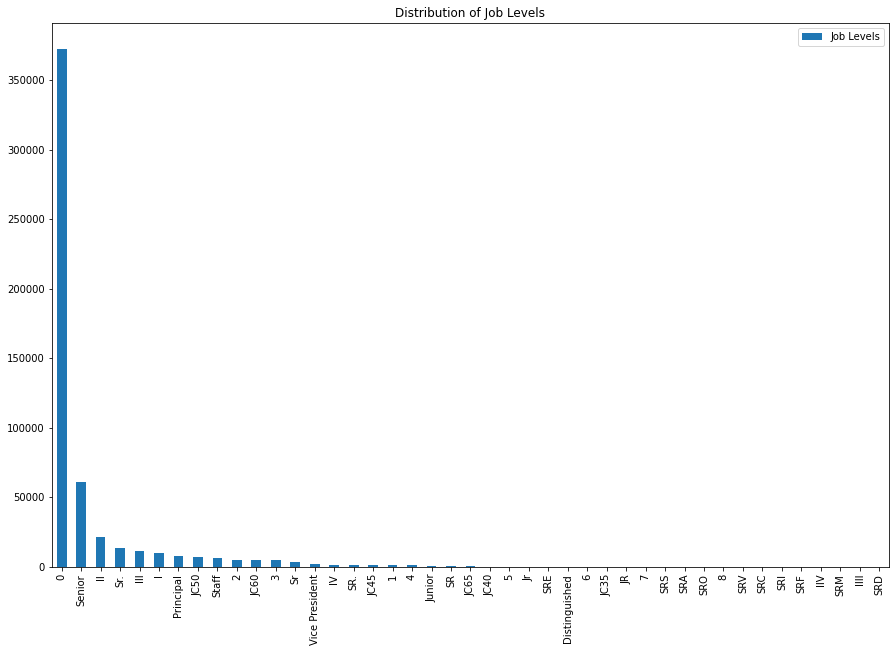

In [ ]:
df_levels = pd.DataFrame(levels.value_counts())
ax = df_levels.plot.bar(figsize=(15, 10), title='Distribution of Job Levels')
ax.legend(['Job Levels'])

#### Simplify and Lemmatize Job Title

First let's take a brief view of the `JOB_TITLES` with a word cloud

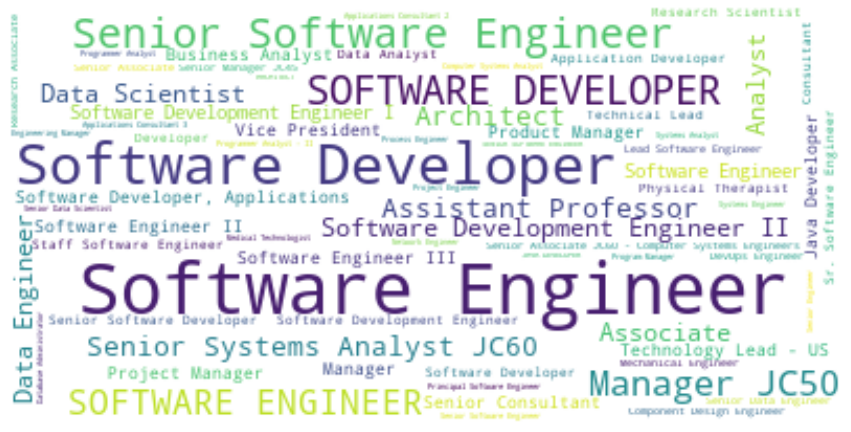

In [ ]:
jobtitles = df2022['JOB_TITLE'].value_counts()
jobtitlesCloud = WordCloud(background_color="white", collocations=False).generate_from_frequencies(jobtitles)
plt.figure( figsize=(15,10))
plt.imshow(jobtitlesCloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Notice that most jobs in the word cloud share similar titles:
* Software Developer v.s. SOFTWARE DEVELOPER
* Software Developer v.s. Software Development Enigineer
* Software Developer, Applications v.s. Software Developer, Application

So we need to lemmatize those jobs to make silimar titles same using nltk WordNetLemmatizer

In [ ]:
def simplify_title(text):
    text = text + ' '
    special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
    text = re.sub(special_char_reg, ' ', text)
    text = re.sub(r'/', ' ', text)
    text = re.sub(r'\s+', ' ', text) #remove all line formattings
    # I II III IV
    text = re.sub(r'\ I+V* ', ' ', text)
    # 1 2 3 4 5
    text = re.sub(r' \d ', ' ', text)
    # JC45 JC50 JC60 JC65
    text = re.sub(r'JC[0-9]{2}', ' ', text)
    # Heading 'Staff', 'Sr', 'SR', 'Sr.', 'SR.', 'Jr', 'Junior', 'Senior', 'Principal', 'Distinguished'
    text = re.sub(r'^Staff|Sr\.|SR.|Sr|SR|Principal|Senior|Jr|JR|Junior|Distinguished', ' ', text)
    # 'Vice President' with punct
    text = text.strip()
    text = re.sub(r'Vice President[,;\s]{1}', '', text)

    word_list = nltk.word_tokenize(text)
    text = ' '.join(WordNetLemmatizer().lemmatize(word.lower().capitalize()) for word in word_list)

    return text
    
titles = df2022['JOB_TITLE'].apply(simplify_title)
df2022['TITLE'] = titles

### Outcome
After the data wrangling, we now have `LEVEL` and `TITLE` separated, `YEAR`, `SALARY`, `CITY`, and `EMPLOYER` standarized, we can safely drop `JOB_TITLE` columns and move on to the **EDA** part.

In [ ]:
df2022 = df2022.drop('JOB_TITLE', axis=1)

In [ ]:
df2022.head(5)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,...,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,PREVAILING_WAGE,PW_WAGE_LEVEL,H_1B_DEPENDENT,SALARY,LEVEL,TITLE
0,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,2021-10-01,1,0,1,0,SUEZ WATER MANAGEMENT SERVICES INC,PARAMUS,NJ,...,No,ATLANTA,GA,2,87485.0,II,No,92000.0,0,Applications Support
1,MECHANICAL DRAFTERS,Y,2021-10-11,1,0,1,0,SENSORS INC,SALINE,MI,...,No,SALINE,MI,1,56181.0,II,No,56181.0,0,Designer
2,OPERATIONS RESEARCH ANALYSTS,Y,2021-10-01,1,1,0,0,HSP GROUP INC,BONITA SPRINGS,FL,...,No,SOMERVILLE,MA,2,59238.0,I,No,60000.0,0,Data Analyst
3,CHEMISTS,Y,2021-10-01,1,1,0,0,ANIP ACQUISITIONS INC,BAUDETTE,MN,...,No,BAUDETTE,MN,1,53851.0,I,No,56160.0,0,Pharmaceutical Chemist
4,COMPUTER SYSTEMS ANALYSTS,Y,2021-10-15,1,1,0,0,COGNIZANT TECHNOLOGY SOLUTIONS US CORP,COLLEGE STATION,TX,...,Yes,CORDOVA,TN,1,70325.0,II,Yes,70325.0,JC60,Systems Analyst


### Save Point

Upon here the Data Wrangling part is finished, we save it to .csv for later usage.

In [ ]:
df2022.to_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_wrangling.csv', index=False)

## **EDA**
---------



#### Load from Save Point

In [ ]:
df2022 = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_wrangling.csv')

#### Salary Outliers

When performing the EDA, we discovered where the previous data processing was inadequate: there were still many outliers in the payroll. So before we officially start EDA, we need to do further processing on the salary column.

Maximum Annual Wage in 2022: $7721.498k = $7721498
Minimum Annual Wage in 2022: $19.2k = $19200
Median Annual Wage in 2022: $109.0k = $109000
Mean Annual Wage in 2022: $118.13535558518235k = $118135


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Boxplot of Annual Wages in 2022')

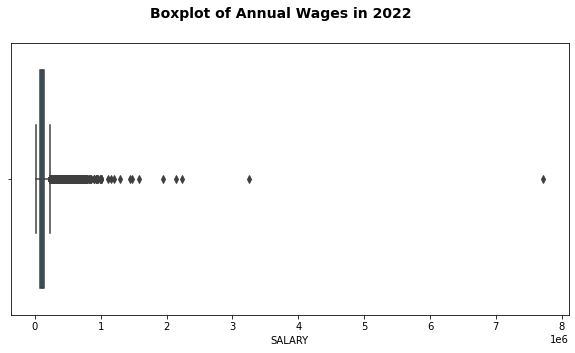

In [ ]:
max_annual_wage = (df2022['SALARY'] / 1000).max()
min_annual_wage  = (df2022['SALARY'] / 1000).min()
med_annual_wage  = (df2022['SALARY'] / 1000).median()
mean_annual_wage  = (df2022['SALARY'] / 1000).mean()

print("Maximum Annual Wage in 2022: $" + str(max_annual_wage) + "k = $" + str(int(max_annual_wage * 1000)))
print("Minimum Annual Wage in 2022: $" + str(min_annual_wage) + "k = $" + str(int(min_annual_wage * 1000)))
print("Median Annual Wage in 2022: $" + str(med_annual_wage) + "k = $" + str(int(med_annual_wage * 1000)))
print("Mean Annual Wage in 2022: $" + str(mean_annual_wage) + "k = $" + str(int(mean_annual_wage * 1000)))
fig = plt.figure(figsize=(10,5))
sns.boxplot(df2022.SALARY)
fig.suptitle('Boxplot of Annual Wages in 2022', fontsize=14, fontweight='bold')

In [ ]:
df2022.sort_values(by = 'SALARY',ascending = False).head(5)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,...,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,PREVAILING_WAGE,PW_WAGE_LEVEL,H_1B_DEPENDENT,SALARY,LEVEL,TITLE
322958,COMPUTER SYSTEMS ENGINEERS/ARCHITECTS,Y,2022-10-01,1,1,0,0,LEXISNEXIS RISK SOLUTIONS FL INC,ALPHARETTA,GA,...,No,PHILADELPHIA,PA,1,56555.0,I,No,7721498.0,II,Software Engineer
350685,"PHYSICIANS AND SURGEONS, ALL OTHER",Y,2022-07-01,1,0,0,0,PULMONICS PLUS PLLC,WAXAHACHIE,TX,...,No,WAXAHACHIE,TX,4,80142.0,I,No,3250000.0,0,Pulmonary & Critical Care Medicine
351902,INFORMATION SECURITY ANALYSTS,Y,2022-06-20,1,0,1,0,META PLATFORMS INC,MENLO PARK,CA,...,No,SAN DIEGO,CA,1,127712.0,IV,Yes,2240000.0,0,Lead Threat Capability & Intent Tracking
252078,FAMILY AND GENERAL PRACTITIONERS,Y,2022-10-27,1,0,0,0,MCLAREN MEDICAL GROUP,FLINT,MI,...,No,PORT HURON,MI,1,190216.0,III,No,2150000.0,0,Physician Of Family Medicine
90811,LAWYERS,Y,2022-01-28,1,0,0,0,VINSON ELKINS L L P,NEW YORK,NY,...,No,NEW YORK,NY,2,226304.0,IV,No,1949000.0,0,Partner


As we can see from the boxplot and the salary in descend order above, even with the first filter of some extreme outliers like 30K+ per hour, there are still some very high salary that is very hard to believe it is correct for some specific job titles. For example, on the top of the list a software engineer II in Philadelphia has a annual salary of **$7.72 Millions** seems very suspicious. We looked up and compared with the prevailing wages for those and believed there might be some typos existing in the original dataset, so we decide to use Inter quantile range method (IQR) to best remove the outliers.

In [ ]:
for x in ['SALARY']:
    q75,q25 = np.percentile(df2022.loc[:,x],[75,25])
    intr_qr = q75-q25 #calculate Interquantile range
 
    max = q75+(1.5*intr_qr) #set the upper limit to Q3 + 1.5*IQR
    min = q25-(1.5*intr_qr) #set the lower limit to Q1-1.5*IQR
 
    df2022.loc[df2022[x] < min,x] = np.nan #change it to nan for the data points that is smaller than the minimum
    df2022.loc[df2022[x] > max,x] = np.nan #change it to nan for the data points that is larger than the maximum

Maximum Annual Wage in 2022: $224.3k = $224300
Minimum Annual Wage in 2022: $19.2k = $19200
Median Annual Wage in 2022: $106.7k = $106700
Mean Annual Wage in 2022: $113.90252683357133k = $113902


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0.98, 'Boxplot of Annual Wages in 2022')

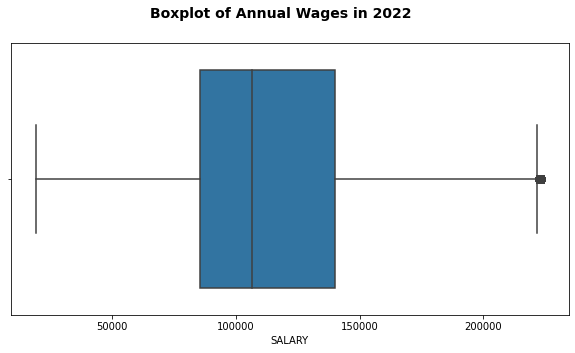

In [ ]:
max_annual_wage = (df2022['SALARY'] / 1000).max()
min_annual_wage  = (df2022['SALARY'] / 1000).min()
med_annual_wage  = (df2022['SALARY'] / 1000).median()
mean_annual_wage  = (df2022['SALARY'] / 1000).mean()

print("Maximum Annual Wage in 2022: $" + str(max_annual_wage) + "k = $" + str(int(max_annual_wage * 1000)))
print("Minimum Annual Wage in 2022: $" + str(min_annual_wage) + "k = $" + str(int(min_annual_wage * 1000)))
print("Median Annual Wage in 2022: $" + str(med_annual_wage) + "k = $" + str(int(med_annual_wage * 1000)))
print("Mean Annual Wage in 2022: $" + str(mean_annual_wage) + "k = $" + str(int(mean_annual_wage * 1000)))
fig = plt.figure(figsize=(10,5))
sns.boxplot(df2022.SALARY)
fig.suptitle('Boxplot of Annual Wages in 2022', fontsize=14, fontweight='bold')

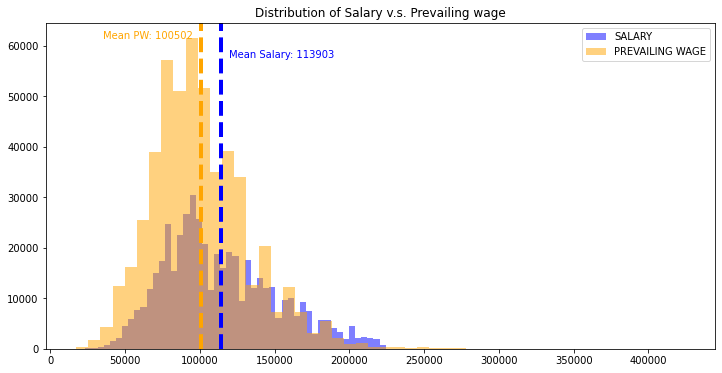

In [ ]:
plt.figure(figsize=(12,6))
x = df2022['SALARY']
y = df2022['PREVAILING_WAGE']

plt.hist(x, bins = 50, alpha=0.5, label='SALARY',color = 'blue')
plt.axvline(x.mean(),color='blue', linestyle='dashed', linewidth=4)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.05, max_ylim*1.8, 'Mean Salary: {:.0f}'.format(x.mean()), color ='blue')
plt.hist(y, bins = 50, alpha=0.5, label='PREVAILING WAGE',color='orange')
plt.axvline(y.mean(),color='orange', linestyle='dashed', linewidth=4)
plt.text(y.mean()* 0.35, max_ylim*1.92, 'Mean PW: {:.0f}'.format(y.mean()), color ='orange')
plt.legend(loc='upper right')
plt.title('Distribution of Salary v.s. Prevailing wage')
plt.show()

After removing the outliers, the boxplot of salary has much fewer outliers on the right hand. The maximum annual wages for 2022 now is \$224,300 which seems much more reasonable than the 7.72 Millions before. The mean of the `PREVAILING WAGE` is \$100,502 and the mean of `SALARY` is \$113,903. The distribution of salary and prevailing salary has a similar distribution which are both normally distributed with a little skewed to the right which can be used for future exploration.

#### Save Point

We dropped all the null values that were created by removing the outliers. Since we changed our dataframe, we created a save point here.


In [ ]:
df2022 = df2022.dropna()
df2022.to_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_eda.csv', index=False)

#### Word Cloud for Jobs

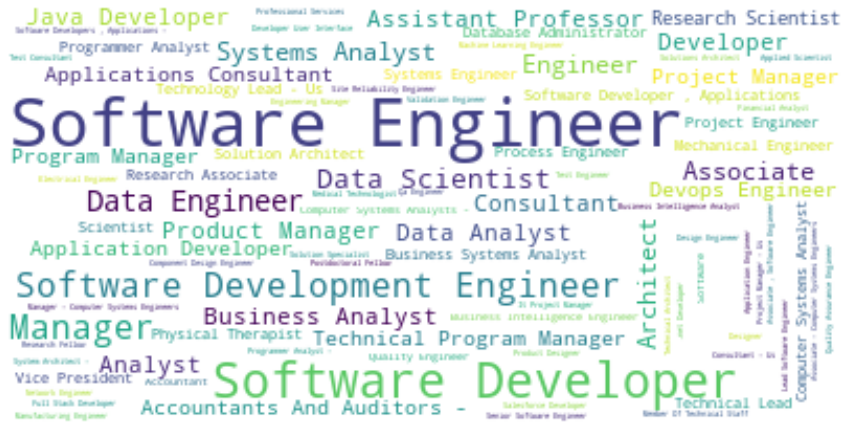

In [ ]:
titles = df2022['TITLE'].value_counts()
wordcloud = WordCloud(background_color="white", collocations=False).generate_from_frequencies(titles)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

After cleaning for the job titles, we want to explore the most frequent titles appear in the database by creating a word cloud. We found that while Software Engineer, Software Developer and Software Development Engineer are the most frequent titles, it seems a little repetitve as they are mostly just the same thing. So we want to do another word cloud with the most common word appears in the job title.

In [ ]:
from nltk.corpus.reader.tagged import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
def tokenize_content(content):
  res = []
  for sentence in content:
    words = word_tokenize(sentence[0])
    filtered_sentence = [word.lower() for word in words if (word.isalpha() and word.lower() not in stopwords)]
    res += filtered_sentence
  return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import collections
keywords = df2022[['TITLE']]
keywords = keywords.values.tolist()
top_tokens = tokenize_content(keywords)
top_most_common = collections.Counter(top_tokens)

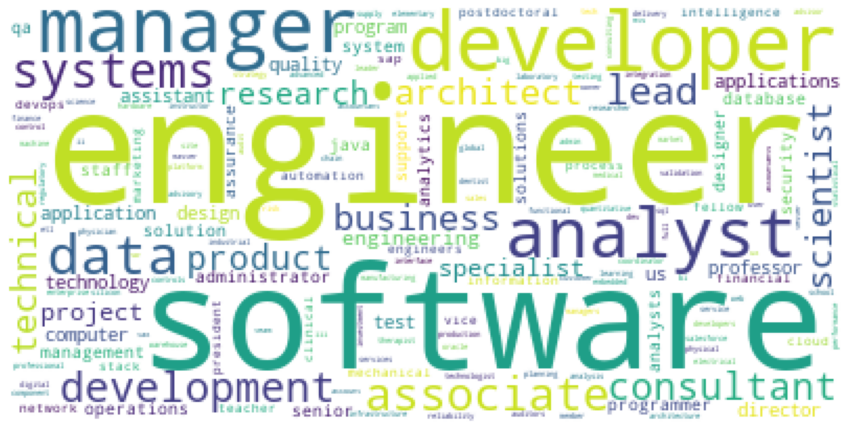

In [ ]:
plt.figure( figsize=(15,10))
wordcloud2 = WordCloud(background_color='white', collocations=False).generate_from_frequencies(top_most_common)
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

Without any doubt, the most common words in the job titles are software and engineer, other popular job titles like analyst, developer, manager, etc also appeared a lot in the H1-B database.

#### Top10 Employed SOC Titles

Text(0.5, 1.0, 'Top 10 SOC Title by Number of Employers')

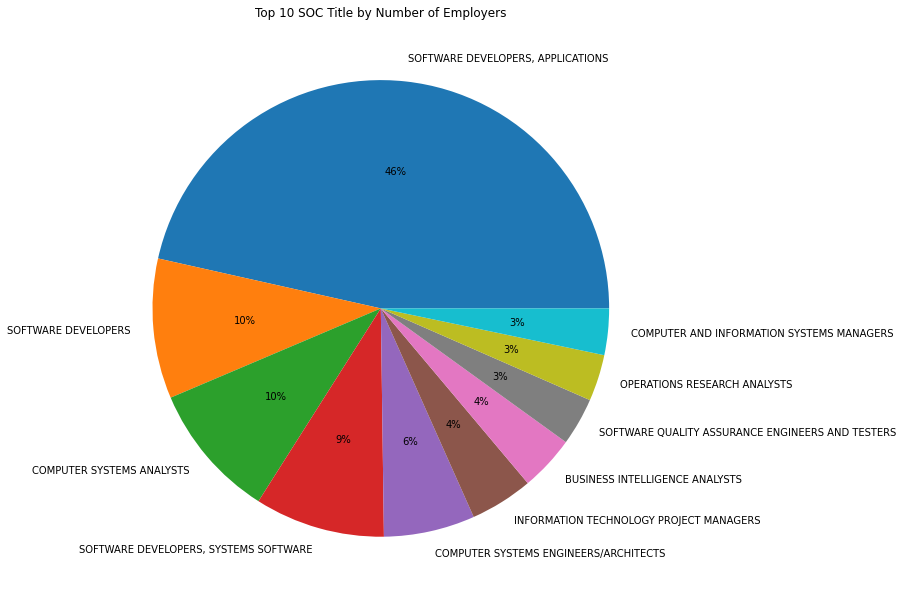

In [ ]:
top10 = df2022.groupby('SOC_TITLE')['TITLE'].count().sort_values(ascending=False).head(10)
labels = top10.index
s = sum(top10.values)
values = list(map(lambda x: (x*100/s), top10.values))

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.pie(x=values, labels=labels, autopct='%.0f%%')
plt.title('Top 10 SOC Title by Number of Employers')

The pie chart shows a clear demonstration of the top 10 most employeed SOC title percentage which shows nearly half of all the most employed SOC titles are software developers, applications. There are also some variation of the software developers which shows the popularity of this job title in the H1-B employers. The other SOC titles are also closely related to the technology industry and required a lot of speciality knowledge.

#### Top and Least Salary SOC Titles

The above graphs have all shown us the popularity and large domination of software engineers and the tech-related job titles in the H1-B database. A simple intuition tells us that there is a strong correlation between job type and salary. This leads us to think about the question does that means software engineers will have a higher average salary than other job titles and does the technology industry will have a salary than other industries? The chart below shows the top 50 and bottom 50 of average salaries for different job types.

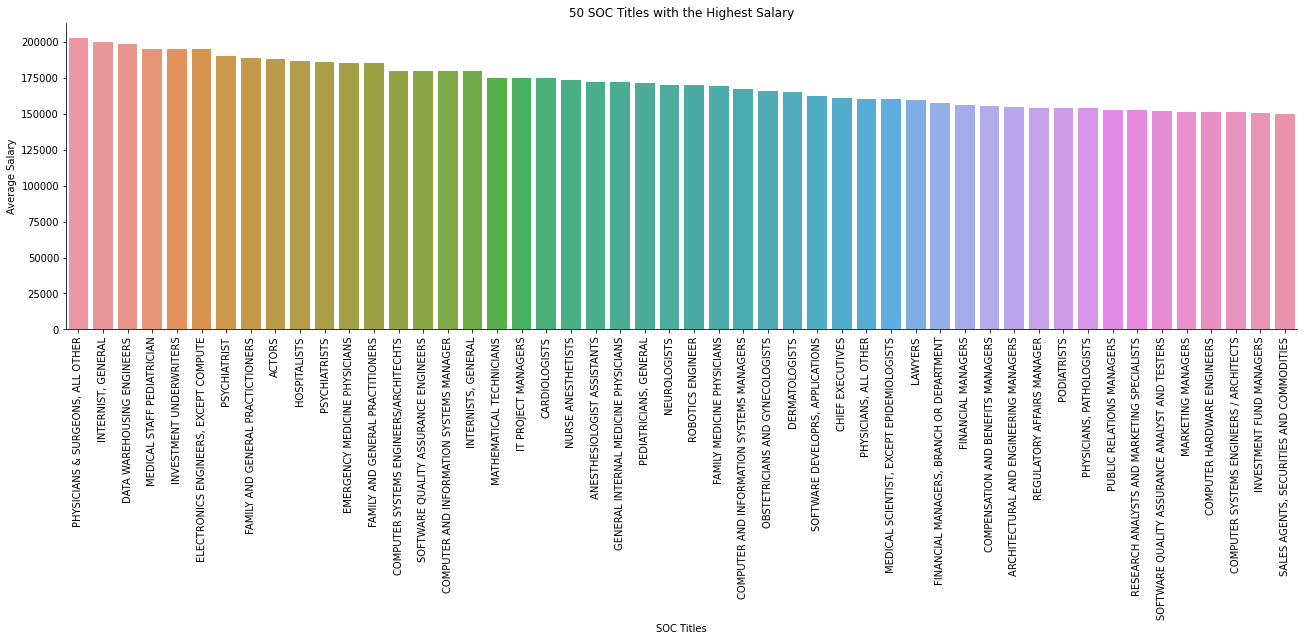

In [ ]:
df2022soc = df2022.groupby(by='SOC_TITLE')['SALARY'].mean().reset_index(drop=False).sort_values(by = 'SALARY', ascending = False)
df2022soct50 = df2022soc.head(50)
g = sns.catplot(data=df2022soct50, x="SOC_TITLE", y="SALARY",kind="bar",aspect=4).set_xticklabels(rotation=90)
plt.title("50 SOC Titles with the Highest Salary")
plt.xlabel('SOC Titles')
plt.ylabel('Average Salary')
plt.show()

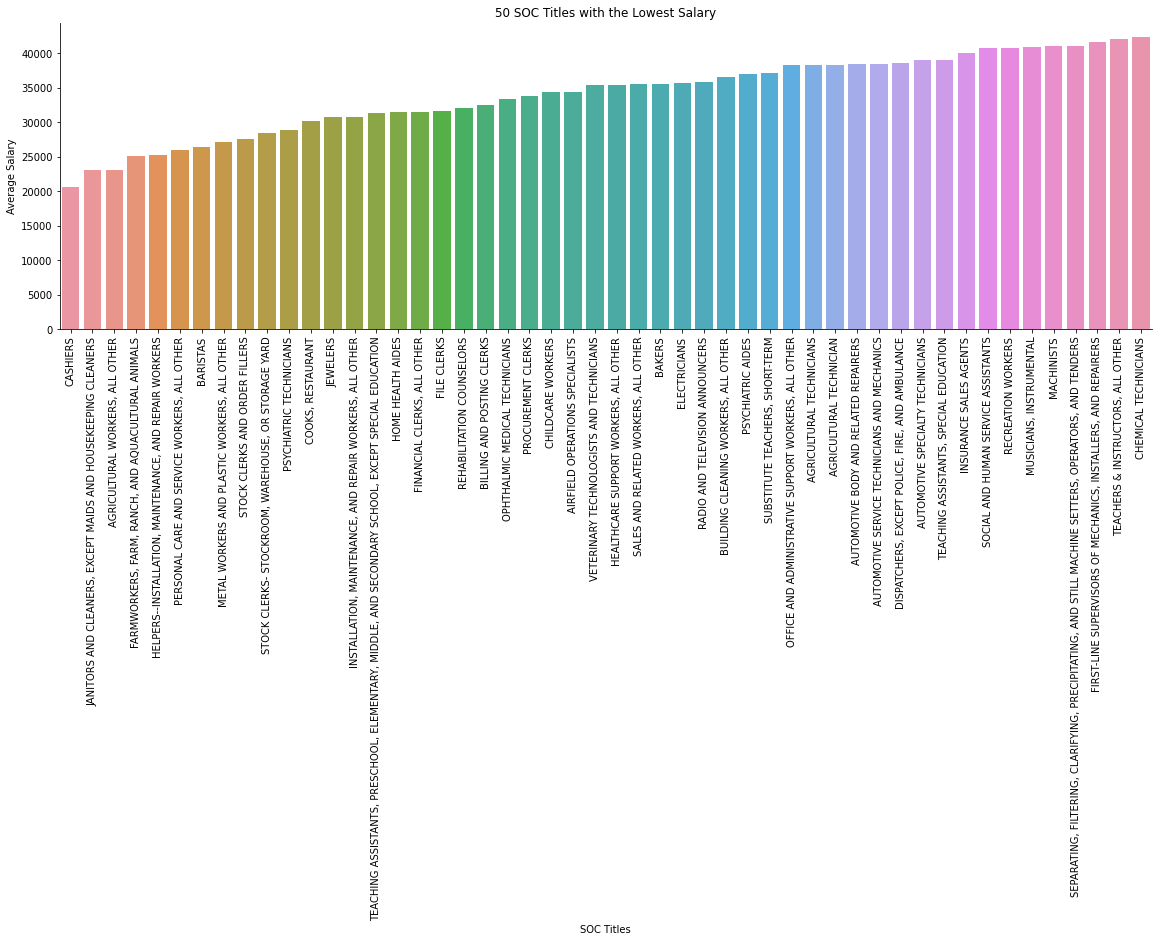

In [ ]:
df2022soctm50 = df2022.groupby(by='SOC_TITLE')['SALARY'].mean().reset_index(drop=False).sort_values(by = 'SALARY', ascending = True).head(50)
g = sns.catplot(data=df2022soctm50, x="SOC_TITLE", y="SALARY",kind="bar",aspect=4).set_xticklabels(rotation=90)
plt.title("50 SOC Titles with the Lowest Salary")
plt.xlabel('SOC Titles')
plt.ylabel('Average Salary')
plt.show()

To our surprise, even though the top 10 most employed SOC titles are all tech-related and software developers has a huge percentage in it, the majority of the SOC titles that has the highest average salary was actually in the medical industry. That is because it is much harder for international students to become a medical professions than to become an engineer in the States. Medical school usually would requires much longer time and more tuition to pursue their degree. On average, it takes as little as 11 years to become a general doctor and some specializations would require 18 years. It is also much harder for international students to pursue a medical degree, according to statistics, international students only make up 0.6\% of all U.S. medical school matriculants. 
 
On the other hand, the SOC titles with the lowest average salary are usually those that do not require any domain knowledge or a higher degree of expertise in it like cashiers, janitors, agriculture workers, etc. Generally, those titles would not be qualified for H1-B visas as one of the major requirements is that the job would require speciality knowledge and must be closely related to the field of study.


#### Geographical Distribution of Salary

In [ ]:
df2022_freq = df2022[['WORKSITE_STATE','SALARY']]
df2022_freq = df2022_freq.groupby(by = 'WORKSITE_STATE').mean().reset_index(drop=False)
df2022_freq.columns = ['WORKSITE_STATE','Average Salary']

fig = px.choropleth(df2022_freq,
                    locations='WORKSITE_STATE', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Average Salary',
                    color_continuous_scale="Viridis_r", 
                    )
fig.update_layout(
      title_text = 'Average Salary by State in 2022',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()

Instead of using the employer state, we choose the worksite state to better represent the average salary for the geographical area. Not so surprisingly, California, Washington, and New York states have the top 3 highest average salaries because California has many technology companies like Meta, Apple, Oracle, etc, Seattle has Amazon headquarters and New York City has many financial companies like JP Morgan Chase Co, Citi and American Express that are paying high salaries. 

#### Geographical Distribution of Number of Employees

In [ ]:
df2022_employee_freq = df2022[['WORKSITE_STATE','EMPLOYER_NAME']]
df2022_employee_freq = df2022_employee_freq.groupby(by = ['WORKSITE_STATE']).count().reset_index(drop=False)
fig = px.choropleth(df2022_employee_freq,
                    locations='WORKSITE_STATE', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='EMPLOYER_NAME',
                    color_continuous_scale="Viridis_r", 
                    )
fig.update_layout(
      title_text = 'Total Number of Employees by State in 2022',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()


California without any doubt has the most employees because of the large number of technology companies. Texas is the second largest state with the most employees as lots of technology companies like Tesla and Oracle has recently moved their headquarters from California to Texas, attracted by the lower rent, living cost, and taxes. Interestingly, the number of employees in each state is very scattered around the US map. While California has about 94K+ employees in 2022, some other states in the West like Wyoming only have 99 employees and Montana has 171 employees. We believe that is not only because of the low population but also due to the lack of companies that is willing to sponsor H1-B in these areas. Next, we would like to take a look at the distribution of the number of employers who sponsored H1-B in the United States to find out whether our assumption is true.
 


####Geographical Distribution of Number of Employers

In [ ]:
df2022_employer_freq = df2022[['WORKSITE_STATE','EMPLOYER_NAME']].drop_duplicates()
df2022_employer_freq = df2022_employer_freq.groupby(by = ['WORKSITE_STATE']).count().reset_index(drop=False)
fig = px.choropleth(df2022_employer_freq,
                    locations='WORKSITE_STATE', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='EMPLOYER_NAME',
                    color_continuous_scale="Viridis_r", 
                    )
fig.update_layout(
      title_text = 'Total Number of Employers by State in 2022',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()


We can find a close similarity between the distribution of the employees and employers which indicates our assumption is correct(except for Washington where Amazon has the headquarters), usually the more employers there are in one State, the more employees there will be. That is because it is very costly and complicated for small companies to file H1-B cases. The employers not only need to pay the prevailing wage for the employees but also have to pay for the H1-B filing cost ranges from \$6,000 to \$10,000 depending on the size of the company and the attorney fee. That is the reason why larger companies would be more willing to hire students who would require H1-B sponsorship as it is very hard for small companies to provide the resources and funds necessary to complete the process while also facing a high risk of rejection.

#### Top 10 employers filing H1-B cases

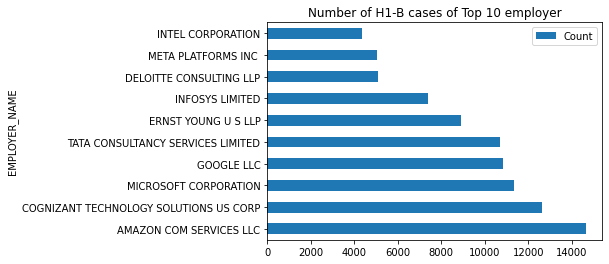

In [ ]:
df2022_employer = df2022[['EMPLOYER_NAME','SALARY']]
df2022_employer = df2022_employer.groupby(by = 'EMPLOYER_NAME').count().sort_values(by = 'SALARY', ascending = False).reset_index(drop=False).head(10)
hist2022_wage = df2022_employer.plot.barh(x = 'EMPLOYER_NAME', y = 'SALARY', title = 'Number of H1-B cases of Top 10 employer')
hist2022_wage.legend(['Count'])
hist2022_wage

As we can see from the barplot, the top 10 employers filing the most H1-B cases are the big companies are either in the technology or consulting industry, as the big company would have more resources to wait for years and wiling to take risks than smaller companies. Interestingly, other than the Big 4 consulting company like Deloitte and EY, the other consulting companies in the chart are all IT consulting company: Cognizant, Tata, Infosys which shows that the majority of the employers who file the most H1-B are still in the technology industry.

## **Feature Engineering**
------

In order to train regression models on the dataset, we would need to convert all of our remaining categorical variables into numerical values. We have divide the feature engineering part into boolean, date and string variables(small, medium, big size) to handle with them separately in the following part.

### Load Save Point

In [ ]:
df2022 = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_eda.csv')

In [ ]:
df2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490026 entries, 0 to 490025
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SOC_TITLE                    490026 non-null  object 
 1   FULL_TIME_POSITION           490026 non-null  object 
 2   BEGIN_DATE                   490026 non-null  object 
 3   TOTAL_WORKER_POSITIONS       490026 non-null  int64  
 4   NEW_EMPLOYMENT               490026 non-null  int64  
 5   CHANGE_EMPLOYER              490026 non-null  int64  
 6   AMENDED_PETITION             490026 non-null  int64  
 7   EMPLOYER_NAME                490026 non-null  object 
 8   EMPLOYER_CITY                490026 non-null  object 
 9   EMPLOYER_STATE               490026 non-null  object 
 10  NAICS_CODE                   490026 non-null  int64  
 11  AGENT_REPRESENTING_EMPLOYER  490026 non-null  object 
 12  WORKSITE_WORKERS             490026 non-null  int64  
 13 

In [ ]:
df2022.select_dtypes(include='object').head(1)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,AGENT_REPRESENTING_EMPLOYER,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,PW_WAGE_LEVEL,H_1B_DEPENDENT,LEVEL,TITLE
0,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,2021-10-01,SUEZ WATER MANAGEMENT SERVICES INC,PARAMUS,NJ,Yes,No,ATLANTA,GA,II,No,0,Applications Support


In [ ]:
df2022.select_dtypes(include=['int', 'float']).head(1)

,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,NAICS_CODE,WORKSITE_WORKERS,TOTAL_WORKSITE_LOCATIONS,PREVAILING_WAGE,SALARY
0,1,0,1,0,221310,1,2,87485.0,92000.0


Now we need to do something with our columns:

* For int and float type, just leave them as they are

* For object: 
    
    - Boolean can be 0 and 1
    - Date can be convert into integer
    - String need to be vectorized

### Boolean

Including columns of `FULL_TIME_POSITION`, `SECONDARY_ENTITY`, `AGENT_REPRESENTING_EMPLOYER`, `H_1B_DEPENDENT`. 

Map Yes to 1 and No to 0.

In [ ]:
df2022['SECONDARY_ENTITY'] = df2022['SECONDARY_ENTITY'].apply(lambda x: 1 if x == 'Yes' else 0)
df2022['AGENT_REPRESENTING_EMPLOYER'] = df2022['AGENT_REPRESENTING_EMPLOYER'].apply(lambda x: 1 if x == 'Yes' else 0)
df2022['H_1B_DEPENDENT'] = df2022['H_1B_DEPENDENT'].apply(lambda x: 1 if x == 'Yes' else 0)
df2022['FULL_TIME_POSITION'] = df2022['FULL_TIME_POSITION'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
df2022.head(1)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,...,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,PREVAILING_WAGE,PW_WAGE_LEVEL,H_1B_DEPENDENT,SALARY,LEVEL,TITLE
0,"SOFTWARE DEVELOPERS, APPLICATIONS",1,2021-10-01,1,0,1,0,SUEZ WATER MANAGEMENT SERVICES INC,PARAMUS,NJ,...,0,ATLANTA,GA,2,87485.0,II,0,92000.0,0,Applications Support


### Date

Including column `BEGIN_DATE`.

Choose 2020-01-01 as start date and calculate the days passed since that day.

In [ ]:
START_DATE = date(2020,1,1)
df2022['BEGIN_DATE'] = df2022['BEGIN_DATE'].apply(lambda s: (date(*map(int, s.split('-'))) - START_DATE).days)

In [ ]:
df2022.head(1)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,...,SECONDARY_ENTITY,WORKSITE_CITY,WORKSITE_STATE,TOTAL_WORKSITE_LOCATIONS,PREVAILING_WAGE,PW_WAGE_LEVEL,H_1B_DEPENDENT,SALARY,LEVEL,TITLE
0,"SOFTWARE DEVELOPERS, APPLICATIONS",1,639,1,0,1,0,SUEZ WATER MANAGEMENT SERVICES INC,PARAMUS,NJ,...,0,ATLANTA,GA,2,87485.0,II,0,92000.0,0,Applications Support


### String

In [ ]:
df2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490026 entries, 0 to 490025
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SOC_TITLE                    490026 non-null  object 
 1   FULL_TIME_POSITION           490026 non-null  int64  
 2   BEGIN_DATE                   490026 non-null  int64  
 3   TOTAL_WORKER_POSITIONS       490026 non-null  int64  
 4   NEW_EMPLOYMENT               490026 non-null  int64  
 5   CHANGE_EMPLOYER              490026 non-null  int64  
 6   AMENDED_PETITION             490026 non-null  int64  
 7   EMPLOYER_NAME                490026 non-null  object 
 8   EMPLOYER_CITY                490026 non-null  object 
 9   EMPLOYER_STATE               490026 non-null  object 
 10  NAICS_CODE                   490026 non-null  int64  
 11  AGENT_REPRESENTING_EMPLOYER  490026 non-null  int64  
 12  WORKSITE_WORKERS             490026 non-null  int64  
 13 

The left object type columns are all string type columns.

In [ ]:
df2022.select_dtypes(include='object').describe()

,SOC_TITLE,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,WORKSITE_CITY,WORKSITE_STATE,PW_WAGE_LEVEL,LEVEL,TITLE
count,490026,490026,490026,490026,490026,490026,490026,490026,490026
unique,799,49404,3545,55,4508,54,4,43,72512
top,"SOFTWARE DEVELOPERS, APPLICATIONS",AMAZON COM SERVICES LLC,NEW YORK,CA,NEW YORK,CA,II,0,Software Engineer
freq,138469,14330,24412,104305,25856,94044,220588,335805,54166


Notice the unique value of each column vary differently, we divided them into three groups by quantities 

1. Small - `PW_WAGE_LEVEL`

2. Medium - `EMPLOYER_STATE`, `WORKSITE_STATE`, `LEVEL`

3. Large - `SOC_TITLE`, `EMPLOYER_NAME`, `EMPLOYER_CITY`, `WORKSITE_CITY`, `TITLE`

#### Small

In [ ]:
df2022['PW_WAGE_LEVEL'].unique()

array(['II', 'I', 'IV', 'III'], dtype=object)

For `PW_WAGE_LEVEL`, it only has unique value of I, II, III, IV and they have ordinal meaning. So we will encode it ordinally.

In [ ]:
def encoder(lv):
  if lv == 'I':
    return 1
  if lv == 'II':
    return 2
  if lv == 'III':
    return 3
  return 4

In [ ]:
df2022['PW_WAGE_LEVEL'] = df2022['PW_WAGE_LEVEL'].apply(encoder)

#### Medium

For `EMPLOYER_STATE`, `WORKSITE_STATE`, we have official code which is called the FIPS codes for each US state.

In [ ]:
def encoder(x):
  state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
  }
  if x in state_codes:
    return int(state_codes[x])
  return None

In [ ]:
df2022['EMPLOYER_STATE'] = df2022['EMPLOYER_STATE'].apply(encoder)
df2022['WORKSITE_STATE'] = df2022['WORKSITE_STATE'].apply(encoder)
df2022 = df2022.dropna()

For LEVEL, it stands for job level

In [ ]:
df2022['LEVEL'].unique()

array(['0', 'JC60', 'JC45', 'JC50', 'Sr.', 'JC65', 'Staff', 'Senior',
       'Principal', 'II', 'III', '3', 'Sr', 'I', 'IV', '4', '2', 'SR.',
       '1', 'Junior', '5', 'SR', 'Jr', 'Vice President', 'JC40', 'SRE',
       'SRC', 'JC35', '6', 'Distinguished', 'SRV', 'SRS', 'JR', '7',
       'SRA', 'SRO', 'SRI', 'SRF', '8', 'IIV', 'SRM', 'IIII', 'SRD'],
      dtype=object)

The level value are complex and simply using a LabelEncoder to map them into 0 to n-1 is not a good idea since this will assume every level is equally far away from each other and that is not true obviously. So we decide to use One-Hot Encoder since there are only 43 of them.

In [ ]:
df2022 = pd.get_dummies(df2022, columns=['LEVEL'], prefix='LEVEL')

In [ ]:
df2022.head(1)

,SOC_TITLE,FULL_TIME_POSITION,BEGIN_DATE,TOTAL_WORKER_POSITIONS,NEW_EMPLOYMENT,CHANGE_EMPLOYER,AMENDED_PETITION,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,...,LEVEL_SRI,LEVEL_SRM,LEVEL_SRO,LEVEL_SRS,LEVEL_SRV,LEVEL_Senior,LEVEL_Sr,LEVEL_Sr.,LEVEL_Staff,LEVEL_Vice President
0,"SOFTWARE DEVELOPERS, APPLICATIONS",1,639,1,0,1,0,SUEZ WATER MANAGEMENT SERVICES INC,PARAMUS,34.0,...,0,0,0,0,0,0,0,0,0,0


#### Large

In this group, the unique numbers of those features are too large to be encoded using One-Hot, but they also do not have ordinal property. So, we decide to use word embeding technique -- Word2Vec to vectorize those features.

##### ***(Skip if not run for the first time)*** Gather all the phrases and tokenize them as the training set

In [ ]:
phrases = list(df2022['SOC_TITLE']) + \
          list(df2022['EMPLOYER_NAME']) + \
          list(df2022['EMPLOYER_CITY']) + \
          list(df2022['WORKSITE_CITY']) + \
          list(df2022['TITLE'])
phrases = list(map(lambda p: re.sub('[^0-9a-zA-Z]+', ' ', str(p)).lower(), phrases))
train_set = [word_tokenize(phrase) for phrase in list(set(phrases))]

##### ***(Skip if not run for the first time)*** Train our Word2Vec model

In [ ]:
model = Word2Vec(train_set,
                min_count=2,
                window=2,
                size=50,
                sample=6e-5, 
                alpha=0.03, 
                min_alpha=0.0007, 
                negative=20)

##### ***(Skip if not run for the first time)*** Save the model for efficiency

In [ ]:
model.save("drive/Shareddrives/CIS545 Project/data/2022/word2vec.model")

##### Load the Word2Vec model

In [ ]:
model = Word2Vec.load("drive/Shareddrives/CIS545 Project/data/2022/word2vec.model")

##### Encoding

To encode a phrase, we are using the average value of embeded words inside it.

As we set the Word2Vec min_count be 2, the word appeared less than 2 times will be droped later.

In [ ]:
def encoder(phrase):
  phrase = re.sub('[^0-9a-zA-Z]+', ' ', phrase).lower()
  words = word_tokenize(phrase)
  s = 0
  c = 0
  for word in words:
    word = word.lower()
    if word in model.wv:
      s += model.wv[word]
      c += 1
  if c == 0:
    return np.nan
  return s / c

Apply the encoder to columns of `SOC_TITLE`, `EMPLOYER_NAME`, `EMPLOYER_CITY`, `WORKSITE_CITY`, `TITLE`. 

Since there are `NAN` value in them, we need to record the indice of `NAN` rows and drop them later.

Expand the new features and concat them to df2022.

In [ ]:
indice_to_drop = []

for col in ['SOC_TITLE', 'EMPLOYER_NAME', 'EMPLOYER_CITY', 'WORKSITE_CITY', 'TITLE']:
  # Need to reset_index to do concat
  df2022 = df2022.reset_index(drop=True)
  # Apply our encoder to one column and this will return a column of 50-dimension vectors
  df = df2022[col].apply(encoder)
  # Get the indice of NaN value
  nan_indice = df[df.isna()].index.to_list()
  # Choose a not NaN value to fill NaN value, or the expanded list cannot be turned into DataFrame
  something_to_fill_nan = df[0] if 0 not in nan_indice else df[nan_indice[0]+1]
  # Fill the NaN value
  for idx in nan_indice:
    df[idx] = something_to_fill_nan
  # Expand the vector to a 50 colmuns DataFrame
  df = pd.DataFrame(df.to_list())
  # Add prefix to the columns
  df = df.add_prefix(col + '_')
  # Concat it with the df2022
  df2022 = pd.concat([df2022, df], axis=1)
  # Update the indice that need to drop later
  indice_to_drop += nan_indice

Drop the rows with word that appeared less than 2 times

In [ ]:
df2022 = df2022.drop(index=indice_to_drop, axis=0)

In [ ]:
df2022 = df2022.reset_index(drop=True)

### Outcome

Drop the string columns

In [ ]:
df2022 = df2022.drop(labels=['SOC_TITLE', 'EMPLOYER_NAME', 'EMPLOYER_CITY', 'WORKSITE_CITY', 'TITLE'], axis=1)

Now the dataset contains only numerical items and it is ready to be used for the modeling part

In [ ]:
df2022.dtypes

FULL_TIME_POSITION          int64
BEGIN_DATE                  int64
TOTAL_WORKER_POSITIONS      int64
NEW_EMPLOYMENT              int64
CHANGE_EMPLOYER             int64
                           ...   
TITLE_45                  float32
TITLE_46                  float32
TITLE_47                  float32
TITLE_48                  float32
TITLE_49                  float32
Length: 310, dtype: object

#### Save Point

In [ ]:
df2022.to_csv('drive/Shareddrives/CIS545 Project/data/2022/feature.csv', index=False)

## **Model**
---------

### Preprocessing

Mainly includes the splitting of the train and test set, 
normalization and PCA for data dimension reduction (one-hot vectors and word vectors resulting in a very large number of features, dimension reduction can effectively improve the computational efficiency and avoid overfitting)

#### Load Save Point

In [ ]:
df2022 = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/feature.csv')

#### Train Test Split

We choose to pick 20% data as test set, since we have 400K+ rows, that's a fair scale test set.

In [ ]:
labels = df2022['SALARY']
features = df2022.drop(columns=['SALARY'])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

#### Standard Scaler

We use standard scaler to do normalization.

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#### PCA

##### ***(Do not re-run, take time)*** Find Dimension n 

In [ ]:
pca = PCA().fit(x_train_scaled)

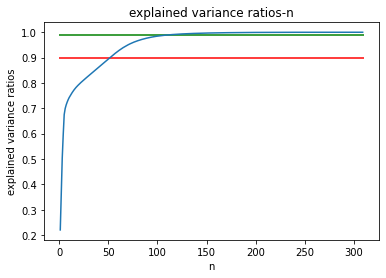

In [ ]:
explained_variance_ratios = pca.explained_variance_ratio_
explained_variance_ratios = sorted(explained_variance_ratios, reverse=True)
ratios=[explained_variance_ratios[0]]
for i in range(1, len(explained_variance_ratios)):
    ratios.append(ratios[i-1] + explained_variance_ratios[i])
plt.plot(np.arange(1, len(explained_variance_ratios) + 1), ratios)
plt.xlabel("n")
plt.title("explained variance ratios-n")
plt.hlines(0.9, xmin=0, xmax=310, label='90% var line', color='red')
plt.hlines(0.99, xmin=0, xmax=310, label='99% var line', color='green')
plt.ylabel("explained variance ratios")
plt.show()

At the beginning, explained variance ratios increase quickly with n, and then the rate of increase gradually slows down, while at the latter the slope is almost zero. We choose the two values of n corresponding to when explained variance ratios equals 90% and 99% respectively. We choose to use 99% with 113 features for the PCA parameter. 

In [ ]:
for i in range(len(ratios)):
  if ratios[i]>0.9:
    print("n with 90%: ", i + 1)
    break
for i in range(len(ratios)):
  if ratios[i]>0.99:
    print("n with 99%: ", i + 1)
    break

n with 90%:  52
n with 99%:  113


##### Do PCA

In [ ]:
pca = PCA(n_components=113)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca =  pca.transform(x_test_scaled)

### Models

#### Metric

Since our label for salary is a number in unit of 10,000, if we use MSE or RMSE as our metrics, the value will be very large and from experiments, they will be larger than 10,000. If we use MSE or RMSE, the value will be confusing and for certain models like Neural Network, it will cause the convergence speed much slower.

So, we decide to use a scale invariant metric -- **Mean Absolute Percentage Error (MAPE)**. It's result is a percentage value between 0 and 1 and the smaller the value is, the better the model is.

#### Decision Tree

First, since from common sense, we should be able to give a rough guess of people's salary based on some reasonable features like employer name, worksite base, job title, job level and so on. Decision Tree should be able to do this job quite well.

##### Decision Tree Regression

In [ ]:
model = DecisionTreeRegressor(random_state = 42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred), '.3f'))
print("Train MAPE value for Decision Tree Regression is: ", mape_train,\
      "\n Test MAPE value for Decision Tree Regression is: ", mape_test,\
      "\n Test error/Train error:", round(mape_test / mape_train, 3))

Train MAPE value for Decision Tree Regression is:  0.002 
 Test MAPE value for Decision Tree Regression is:  0.097 
 Test error/Train error: 48.5


Comparing the training error/test error, we can see that the overfitting phenomenon is more serious. 

We can try to reduce the overfitting with limiting the max depth.


##### Decision Tree Regression with max depth

We set a max_depth of 25.

In [ ]:
model = DecisionTreeRegressor(random_state = 42, max_depth=25)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("Train MAPE value for Decision Tree Regression with PCA is: ", mape_train,
      "\n Test MAPE value for Decision Tree Regression with PCA is: ", mape_test,
      "\n Test error/Train error:",mape_test/mape_train)

Train MAPE value for Decision Tree Regression with PCA is:  0.023 
 Test MAPE value for Decision Tree Regression with PCA is:  0.095 
 Test error/Train error: 4.130434782608695


As we can see, after setting a smaller max_depth, the ratio of Test error/Train error significantly decreased while the test error decreased too, which means our method against overfitting in decision tree works and it also gives us a better model on test set.


#### KNN

Intuitively, if we want to guess someone's salary, we will first ask a few questions about that this person (which company, what job, and so on) and try to match the information with people we know who is very similar to the unknown person. We will be positive that the unknown person's salary should be similar with the person we know. This is basiclly Nearest Neighbor.

So, we would like to try KNN on our data.

##### ***(Take hours, please do not run again)*** Choosing K 

In [ ]:
mape_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(x_train, y_train)  #fit the model
    y_pred=model.predict(x_test) #make prediction on test set
    mape = mean_absolute_percentage_error(y_test, y_pred) #calculate mape
    mape_val.append(mape) #store mape values
    print('MAPE value for k =' , K , 'is:', mape)

MAPE value for k = 1 is: 0.11186171476833998
MAPE value for k = 2 is: 0.10869985479544914
MAPE value for k = 3 is: 0.108007297810861
MAPE value for k = 4 is: 0.10778402695999521
MAPE value for k = 5 is: 0.10779164336549407
MAPE value for k = 6 is: 0.1084664513086121
MAPE value for k = 7 is: 0.10891711112592171
MAPE value for k = 8 is: 0.1093162995272876
MAPE value for k = 9 is: 0.10987962004435908
MAPE value for k = 10 is: 0.11019195503222877


Text(0, 0.5, 'Mean Absolute Percentage Error')

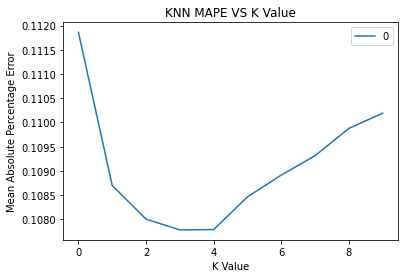

In [ ]:
curve = pd.DataFrame(mape_val) #elbow curve 
curve.plot()
plt.title('KNN MAPE VS K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Percentage Error')

##### Choose K = 4

In [ ]:
print('MAPE value for k = 4 is: 0.10778402695999521')

MAPE value for k = 4 is: 0.10778402695999521


The result of KNN is slightly worse than decision tree and it also runs slower than decision tree since our dataset has 400K+ rows.

#### Linear Models

Well, it's no harm to try linear regression on our data since it's usually simple and fast. However, we do not expect a good performance from linear regression and it's regularized editions because the features we use involves semantic meaning like company name, titles, and so on. So they should not be able to be linearly represented from intuition. 

##### Ordinary Linear Regression

In [ ]:
reg = LinearRegression().fit(x_train, y_train)
y_pred_lr = reg.predict(x_test)
score_test = reg.score(x_test, y_test)
score_train = reg.score(x_train, y_train)
y_train_pred = reg.predict(x_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_lr), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\n Test R^2 value for Linear Regression model is: ", score_test,\
      "\n Train R^2 value for Linear Regression model is: ", score_train)
print("\n Test MAPE value for Linear Regression model is: ", mape_test,\
      "\n Train MAPE value for Linear Regression model is: ", mape_train,\
      "\n Test error/Train error:",mape_test/mape_train)


 Test R^2 value for Linear Regression model is:  -91487.97004827134 
 Train R^2 value for Linear Regression model is:  0.7713713461370019

 Test MAPE value for Linear Regression model is:  0.7 
 Train MAPE value for Linear Regression model is:  0.118 
 Test error/Train error: 5.932203389830509


Well the R2 score and test MAPE value shows that the model is terribly bad.

#####Linear Regression with PCA

Maybe there exists collinearity among our features. 

Let's see if PCA can help.

In [ ]:
lr_pca = LinearRegression().fit(x_train_pca, y_train)
y_pred_lr_pca = lr_pca.predict(x_test_pca)
y_train_pred = lr_pca.predict(x_train_pca)
score_test = lr_pca.score(x_test_pca, y_test)
score_train = lr_pca.score(x_train_pca, y_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_lr_pca), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\n Test R^2 value for Linear Regression model is: ", score_test,\
      "\n Train R^2 value for Linear Regression model is: ", score_train)
print("\n Test MAPE value for Linear Regression model is: ", mape_test,\
      "\n Train MAPE value for Linear Regression model is: ", mape_train,\
      "\n Test error/Train error:", mape_test/mape_train)


 Test R^2 value for Linear Regression model is:  0.746832945596321 
 Train R^2 value for Linear Regression model is:  0.7490479646047445

 Test MAPE value for Linear Regression model is:  0.124 
 Train MAPE value for Linear Regression model is:  0.124 
 Test error/Train error: 1.0


PCA effectively removes collinearity and reduces overfitting by reducing the number of features, even though it slightly boosts the training error. 

So, we should consider there are colinearity among our features from the experiment above.

Let's look at the graph of the linear regression coefficient.

Text(0.5, 1.0, 'Coeffient')

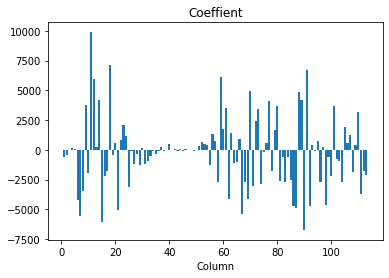

In [ ]:
x=np.arange(1,len(lr_pca.coef_)+1,1)
plt.bar(x,lr_pca.coef_)
plt.xlabel("Column")
plt.title("Coeffient")

We can see that some features have large coefficient values and others are small. 

This should be a good scenario to apply Ridge and LASSO since they are good at handling significant features.

We will try Ridge and LASSO on original data without PCA and we should expect they show similar result from Linear Regression with PCA.

And also their combination - Elastic Net linear regression.

##### Regularized Linear Regression

**Ridge**

In [ ]:
ridge = Ridge(alpha=1).fit(x_train, y_train)
y_pred_ridge = ridge.predict(x_test)
y_train_pred = ridge.predict(x_train)
score_test = ridge.score(x_test, y_test)
score_train = ridge.score(x_train, y_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_ridge), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\n Test R^2 value for Linear Regression model with Ridge Regularization is: ", score_test,\
      "\n Train R^2 value for Linear Regression model with Ridge Regularization is: ", score_train)
print("\n Test MAPE value for Linear Regression model with Ridge Regularization is: ", mape_test,\
      "\n Train MAPE value for Linear Regression model with Ridge Regularization is: ", mape_train,\
      "\n Test error/Train error:", mape_test/mape_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.10333e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T



 Test R^2 value for Linear Regression model with Ridge Regularization is:  0.7671915089367072 
 Train R^2 value for Linear Regression model with Ridge Regularization is:  0.7693064658495681

 Test MAPE value for Linear Regression model with Ridge Regularization is:  0.118 
 Train MAPE value for Linear Regression model with Ridge Regularization is:  0.118 
 Test error/Train error: 1.0


**LASSO**

In [ ]:
lasso = Lasso(alpha=1).fit(x_train, y_train)
y_pred_lasso = lasso.predict(x_test)
y_train_pred = lasso.predict(x_train)
score_test = lasso.score(x_test, y_test)
score_train = lasso.score(x_train, y_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_lasso), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\n Test R^2 value for Linear Regression model with Lasso Regularization is: ", score_test,\
      "\n Train R^2 value for Linear Regression model with Lasso Regularization is: ", score_train)
print("\n Test MAPE value for Linear Regression model with Lasso Regularization is: ", mape_test,\
      "\n Train MAPE value for Linear Regression model with Lasso Regularization |is: ", mape_train,\
      "\n Test error/Train error:",mape_test/mape_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.739e+13, tolerance: 4.610e+10
  model = cd_fast.enet_coordinate_descent(



 Test R^2 value for Linear Regression model with Lasso Regularization is:  0.760864076769688 
 Train R^2 value for Linear Regression model with Lasso Regularization is:  0.7630418543037242

 Test MAPE value for Linear Regression model with Lasso Regularization is:  0.119 
 Train MAPE value for Linear Regression model with Lasso Regularization |is:  0.12 
 Test error/Train error: 0.9916666666666667


As we expected, Ridge and LASSO show similar and slightly better performance comparing with PCA linear regression. We think that's because Ridge and LASSO did similar job as PCA did, they show preference on some columns while ignore other not useful columns. That's somewhat equivalent with do dimension redcution using PCA in advance. However, running LASSO is much slower than running the other two methods. That maybe due to PCA can be pre-calculated. And Ridge is doing square sum which can be done using matices while LASSO is calculating absolute value which cannot be written in matrice form.

**Elastic Net**

We do it with the default parameters: `alpha = 1` and `l1_ratio = 0.5`

In [ ]:
e_net = ElasticNet(alpha = 1, l1_ratio=0.5).fit(x_train, y_train)
y_pred_e_net = e_net.predict(x_test)
y_train_pred = e_net.predict(x_train)
score_test = e_net.score(x_test, y_test)
score_train = e_net.score(x_train, y_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_e_net), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\nTest R^2 value for Linear Regression model with Elastic Net Regularization is: ", score_test,\
      "\nTrain R^2 value for Linear Regression model with Elastic Net Regularization is: ", score_train)
print("\nTest MAPE value for Linear Regression model with Elastic Net Regularization is: ", mape_test,\
      "\nTrain MAPE value for Linear Regression model with Elastic Net Regularization is: ", mape_train,\
      "\ntest error/Train error:", mape_test/mape_train)


Test R^2 value for Linear Regression model with Elastic Net Regularization is:  0.7122810877907342 
Train R^2 value for Linear Regression model with Elastic Net Regularization is:  0.714821768908297

Test MAPE value for Linear Regression model with Elastic Net Regularization is:  0.134 
Train MAPE value for Linear Regression model with Elastic Net Regularization is:  0.135 
test error/Train error: 0.9925925925925926


Elastic Net is the combination of L1 and L2 regularization and it shows different results as the previous three models in that it's worse. 😞

However, we believe it can do better and the bad performance is just due to we chose bad hyper-parameters.

We will try to find what we can do in the next part.

##### Model Selection

Below is the coeffients plot of the previous four models.

Text(0.5, 1.0, 'Coeffients ElasticNet')

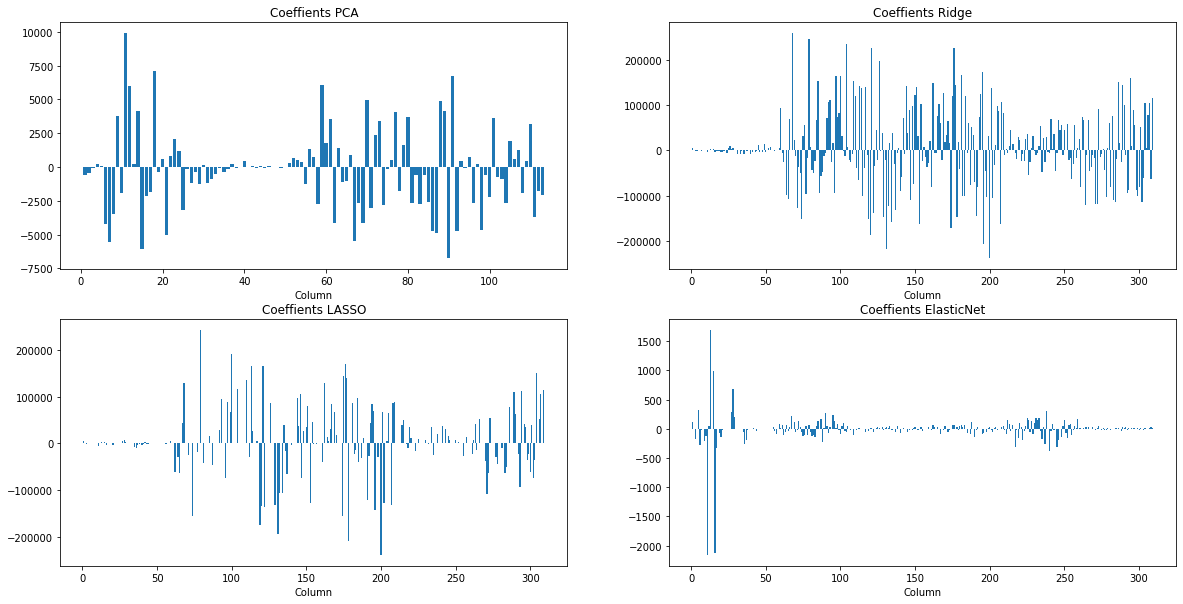

In [ ]:
x=np.arange(1,len(lr_pca.coef_)+1,1)
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.bar(x, lr_pca.coef_)
plt.xlabel("Column")
plt.title("Coeffients PCA")
x=np.arange(1,len(ridge.coef_)+1,1)
plt.subplot(2, 2, 2)
plt.bar(x, ridge.coef_)
plt.xlabel("Column")
plt.title("Coeffients Ridge")
plt.subplot(2, 2, 3)
plt.bar(x, lasso.coef_)
plt.xlabel("Column")
plt.title("Coeffients LASSO")
plt.subplot(2, 2, 4)
plt.bar(x, e_net.coef_)
plt.xlabel("Column")
plt.title("Coeffients ElasticNet")

It appears that the regression with regularization does not significantly affect the values of the coefficients, except for regression model with Elastic Net Regularization. However, in terms of MAPE, the Elastic Net model performs even worse. The next step is to use GridSearch for auto-referencing to investigate whether regularization can help us optimize the model.

Since Elastic Net has two hyper-parameters: `alpha` and `l1_ratio`. We will do GridSearchCV on both of them, from 0.05 to 0.95 for both using cross validation on 5 folds.

In [ ]:
param_grid = {"alpha":np.arange(0.05,0.95,0.1),"l1_ratio":np.arange(0.05,0.95,0.1)}
grid_search = GridSearchCV(ElasticNet(),param_grid,cv=5) 
grid_search.fit(x_train_pca, y_train)
print("Test set score:{:.2f}".format(grid_search.score(x_test_pca,y_test)))
print("Best parameters:{}".format(grid_search.best_params_))
print("Best score on train set:{:.2f}".format(grid_search.best_score_))

Test set score:0.75
Best parameters:{'alpha': 0.05, 'l1_ratio': 0.8500000000000002}
Best score on train set:0.75


Let's see what happens using the best parameters 😮

In [ ]:
e_net_best = ElasticNet(alpha = 0.05, l1_ratio=0.85).fit(x_train, y_train)
y_pred_e_net_best = e_net_best.predict(x_test)
y_train_pred = e_net_best.predict(x_train)
score_test = e_net_best.score(x_test, y_test)
score_train = e_net_best.score(x_train, y_train)
mape_test = float(format(mean_absolute_percentage_error(y_test, y_pred_e_net), '.3f'))
mape_train = float(format(mean_absolute_percentage_error(y_train, y_train_pred), '.3f'))
print("\nTest R^2 value for Best Elastic Net is: ", score_test,\
      "\nTrain R^2 value for Best Elastic Net is: ", score_train)
print("\nTest MAPE value for Best Elastic Net is: ", mape_test,\
      "\nTrain MAPE value for Best Elastic Net is: ", mape_train,\
      "\ntest error/Train error:", mape_test/mape_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.307e+13, tolerance: 4.610e+10
  model = cd_fast.enet_coordinate_descent(



Test R^2 value for Best Elastic Net is:  0.7261214686608142 
Train R^2 value for Best Elastic Net is:  0.7283460454858057

Test MAPE value for Best Elastic Net is:  0.134 
Train MAPE value for Best Elastic Net is:  0.13 
test error/Train error: 1.0307692307692309


It is very unfortunate that the scores of the Regression model with Elastic Net Regularization with optimal hyper-parameters are worse than Ridge alone or LASSO alone or ordinary Linear Regression with PCA. 

We have to admit that linear model and regularization does not help much on our task since none of these linear models behave better than a single decision tree. 😞

#### Neural Network

##### GPU runtime

If you want to run codes in this section, you'd better change to GPU runtime because we are using PyTorch.

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

1.13.0+cu116
cuda:0


##### Net Structure

After several experiments, we are using a 4-layer FNN with activation layer using ReLU.

In [ ]:
class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear_relu1 = nn.Sequential(nn.Linear(input_dim, 512), self.relu)
        self.linear_relu2 = nn.Sequential(nn.Linear(512, 256), self.relu)
        self.linear_relu3 = nn.Sequential(nn.Linear(256, 256), self.relu)
        self.linear_relu4 = nn.Sequential(nn.Linear(256, 128), self.relu)
        self.output = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.linear_relu1(x)
        x = self.linear_relu2(x)
        x = self.linear_relu3(x)
        x = self.linear_relu4(x)
        return self.output(x)

##### Importance of Label Scaling

As mentioned before, our label is the salary and salary is in unit of 10,000. 

For PyTorch, if we use the ordinary scale-variant Loss Function like MSE (mostly used in regression), the loss will certainly become a huge number and under normal learning rate setting, it will take ages to converge. 

Below is an example of this phenomenon.

**Unscaled Label**

In [ ]:
x_train_tensor = torch.tensor(x_train_pca, dtype=torch.float).to(device=device)
y_train_tensor = torch.tensor(y_train.to_numpy().reshape((-1,1)), dtype=torch.float).to(device=device)

In [ ]:
%%time
fnn = FNN(input_dim=x_train_tensor.shape[1]).to(device=device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(fnn.parameters(), lr=1e-2)
losses = []
mses = []

for t in range(100):
  pred = fnn(x_train_tensor)
  loss = criterion(pred, y_train_tensor)
  losses.append(loss.item())
  mse = sqrt((torch.sum((pred - y_train_tensor)**2) / len(y_train_tensor)).item())
  mses.append(mse)
  if t % 10 == 0:
    print("The training loss for Epoch {} is: {}, MSE = {}".format(t, loss, mse))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

The training loss for Epoch 0 is: 14674197504.0, MSE = 121137.10209510544
The training loss for Epoch 10 is: 5870626816.0, MSE = 76620.01576611688
The training loss for Epoch 20 is: 2013498880.0, MSE = 44872.02781243567
The training loss for Epoch 30 is: 850471040.0, MSE = 29162.83662471811
The training loss for Epoch 40 is: 696612352.0, MSE = 26393.41493630561
The training loss for Epoch 50 is: 536965760.0, MSE = 23172.521658205435
The training loss for Epoch 60 is: 450452352.0, MSE = 21223.862796390295
The training loss for Epoch 70 is: 420968384.0, MSE = 20517.514079439545
The training loss for Epoch 80 is: 396018944.0, MSE = 19900.22472234924
The training loss for Epoch 90 is: 378228960.0, MSE = 19448.109419683962
CPU times: user 14.9 s, sys: 31.5 ms, total: 15 s
Wall time: 15 s


Our learning rate is 0.01 which is quite large. But as you can see, the loss after 100 epoches are still in unit of 100 million.

So we have to scale the label.

**Scaled Label**

We will scale the label before training and if we want to get the real prediction value, we can do an inverse transformation.

In [ ]:
label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train.to_numpy().reshape((-1,1)))
print(f"Label Scaled with mean: {label_scaler.mean_} and variance: {label_scaler.var_}")
x_train_tensor = torch.tensor(x_train_pca, dtype=torch.float).to(device=device)
y_train_tensor = torch.tensor((y_train_scaled), dtype=torch.float).to(device=device)

Label Scaled with mean: [114787.58327864] and variance: [1.49801645e+09]


We train the FNN model with learning rate `0.0001` and `1000` epoches. 

These two hyper-parameters are derived from experiments.

In [ ]:
%%time
fnn = FNN(input_dim=x_train_tensor.shape[1]).to(device=device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
losses = []
mses = []

for t in range(1000):
  pred = fnn(x_train_tensor)
  loss = criterion(pred, y_train_tensor)
  losses.append(loss.item())
  mse = (torch.sum((pred - y_train_tensor)**2) / len(y_train_tensor)).item()
  mses.append(mse)
  if t % 10 == 0:
    print("The training loss for Epoch {} is: {}, MSE = {}".format(t, loss, mse))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

The training loss for Epoch 0 is: 0.9974595904350281, MSE = 0.9974595904350281
The training loss for Epoch 10 is: 0.935476541519165, MSE = 0.935476541519165
The training loss for Epoch 20 is: 0.831853985786438, MSE = 0.831853985786438
The training loss for Epoch 30 is: 0.6556940674781799, MSE = 0.6556940674781799
The training loss for Epoch 40 is: 0.4446139931678772, MSE = 0.4446139931678772
The training loss for Epoch 50 is: 0.3262389004230499, MSE = 0.3262389004230499
The training loss for Epoch 60 is: 0.27442851662635803, MSE = 0.27442851662635803
The training loss for Epoch 70 is: 0.254031777381897, MSE = 0.254031777381897
The training loss for Epoch 80 is: 0.24292755126953125, MSE = 0.24292755126953125
The training loss for Epoch 90 is: 0.2356962412595749, MSE = 0.2356962412595749
The training loss for Epoch 100 is: 0.23043237626552582, MSE = 0.23043237626552582
The training loss for Epoch 110 is: 0.22612150013446808, MSE = 0.22612150013446808
The training loss for Epoch 120 is: 0

##### Training Curves

Text(0, 0.5, 'Loss')

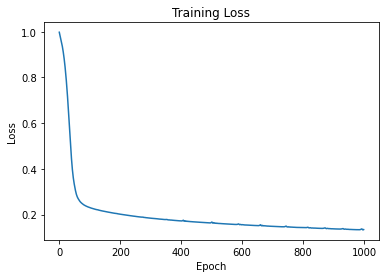

In [ ]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'MSE')

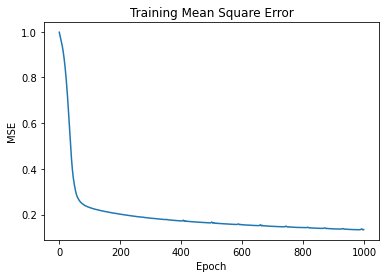

In [ ]:
plt.plot(mses)
plt.title('Training Mean Square Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')

Those two curves are pretty smooth and meet our expectation, which means our FNN structure and hyper parameters setting are reasonable.

##### MAPE Evaluation

In [ ]:
x_test_tensor = torch.tensor(x_test_pca, dtype=torch.float).to(device=device)
y_pred = label_scaler.inverse_transform(fnn(x_test_tensor).detach().cpu())
mape = float(format(mean_absolute_percentage_error(y_test, y_pred), '.3f'))
print("\nMAPE value for Neural Network is: ", mape)


MAPE value for Neural Network is:  0.097


With no surprise, FNN gets nearly identical result as Decision Tree which is our previous best model.

To our knowledge, that is because our feature includes many semantic information which are hard to model with linear relations. Neural Network can better represent them with non-linearity modeling ability (activation node).

##### Model Selection

We want to find out a best FNN model without changing our net structure.

Use K-Fold cross validation to select the best FNN model. Here K = 5.

Because we are using PyTorch, we have to do this manually.

In [ ]:
%%time
kf = KFold(n_splits=5)
kf.get_n_splits(x_train_pca)

mapes = []
fnns = []

for i, (train_index, test_index) in enumerate(kf.split(x_train_pca)):
    print(f"Fold {i}:")
    # train test split
    x_train_kfold, y_train_kfold = x_train_pca[[train_index]], y_train.to_numpy().reshape((-1,1))[[train_index]]
    x_test_kfold, y_test_kfold = x_train_pca[[test_index]], y_train.to_numpy().reshape((-1,1))[[test_index]]
    # trainset prepare
    kfold_scaler = StandardScaler()
    y_train_scaled = kfold_scaler.fit_transform(y_train_kfold)
    x_train_tensor = torch.tensor(x_train_kfold, dtype=torch.float).to(device=device)
    y_train_tensor = torch.tensor((y_train_scaled), dtype=torch.float).to(device=device)
    # model initialize
    fnn = FNN(input_dim=x_train_tensor.shape[1]).to(device=device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(fnn.parameters(), lr=1e-4)
    # train
    for t in range(1000):
      pred = fnn(x_train_tensor)
      loss = criterion(pred, y_train_tensor)
      mse = (torch.sum((pred - y_train_tensor)**2) / len(y_train_tensor)).item()
      if t % 100 == 0:
        print(f"The training loss for Epoch {t} is: {loss}, MSE = {mse}")
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # evaluation
    x_test_tensor = torch.tensor(x_test_kfold, dtype=torch.float).to(device=device)
    y_pred = kfold_scaler.inverse_transform(fnn(x_test_tensor).detach().cpu())
    mape = float(format(mean_absolute_percentage_error(y_test_kfold, y_pred), '.3f'))
    # record
    mapes.append(mape)
    fnns.append(fnn)

Fold 0:


<timed exec>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
<timed exec>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


The training loss for Epoch 0 is: 1.0042837858200073, MSE = 1.0042837858200073
The training loss for Epoch 100 is: 0.2313951700925827, MSE = 0.2313951700925827
The training loss for Epoch 200 is: 0.2018631249666214, MSE = 0.2018631249666214
The training loss for Epoch 300 is: 0.18413929641246796, MSE = 0.18413929641246796
The training loss for Epoch 400 is: 0.1715957224369049, MSE = 0.1715957224369049
The training loss for Epoch 500 is: 0.16172613203525543, MSE = 0.16172613203525543
The training loss for Epoch 600 is: 0.15370848774909973, MSE = 0.15370848774909973
The training loss for Epoch 700 is: 0.14693646132946014, MSE = 0.14693646132946014
The training loss for Epoch 800 is: 0.1460760086774826, MSE = 0.1460760086774826
The training loss for Epoch 900 is: 0.1368526816368103, MSE = 0.1368526816368103
Fold 1:


<timed exec>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
<timed exec>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


The training loss for Epoch 0 is: 1.0052490234375, MSE = 1.0052490234375
The training loss for Epoch 100 is: 0.23101277649402618, MSE = 0.23101277649402618
The training loss for Epoch 200 is: 0.20055827498435974, MSE = 0.20055827498435974
The training loss for Epoch 300 is: 0.18333125114440918, MSE = 0.18333125114440918
The training loss for Epoch 400 is: 0.1708795428276062, MSE = 0.1708795428276062
The training loss for Epoch 500 is: 0.16140948235988617, MSE = 0.16140948235988617
The training loss for Epoch 600 is: 0.15371093153953552, MSE = 0.15371093153953552
The training loss for Epoch 700 is: 0.14676310122013092, MSE = 0.14676310122013092
The training loss for Epoch 800 is: 0.14072202146053314, MSE = 0.14072202146053314
The training loss for Epoch 900 is: 0.1369675099849701, MSE = 0.1369675099849701
Fold 2:
The training loss for Epoch 0 is: 1.0034164190292358, MSE = 1.0034164190292358


<timed exec>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
<timed exec>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


The training loss for Epoch 100 is: 0.23082761466503143, MSE = 0.23082761466503143
The training loss for Epoch 200 is: 0.2029677927494049, MSE = 0.2029677927494049
The training loss for Epoch 300 is: 0.18469549715518951, MSE = 0.18469549715518951
The training loss for Epoch 400 is: 0.17196659743785858, MSE = 0.17196659743785858
The training loss for Epoch 500 is: 0.16209597885608673, MSE = 0.16209597885608673
The training loss for Epoch 600 is: 0.15388117730617523, MSE = 0.15388117730617523
The training loss for Epoch 700 is: 0.14659476280212402, MSE = 0.14659476280212402
The training loss for Epoch 800 is: 0.14027778804302216, MSE = 0.14027778804302216
The training loss for Epoch 900 is: 0.13452793657779694, MSE = 0.13452793657779694
Fold 3:
The training loss for Epoch 0 is: 1.0040607452392578, MSE = 1.0040607452392578


<timed exec>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
<timed exec>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


The training loss for Epoch 100 is: 0.23204191029071808, MSE = 0.23204191029071808
The training loss for Epoch 200 is: 0.20298689603805542, MSE = 0.20298689603805542
The training loss for Epoch 300 is: 0.1843719184398651, MSE = 0.1843719184398651
The training loss for Epoch 400 is: 0.17105118930339813, MSE = 0.17105118930339813
The training loss for Epoch 500 is: 0.16214418411254883, MSE = 0.16214418411254883
The training loss for Epoch 600 is: 0.15204453468322754, MSE = 0.15204453468322754
The training loss for Epoch 700 is: 0.14486557245254517, MSE = 0.14486557245254517
The training loss for Epoch 800 is: 0.13854190707206726, MSE = 0.13854190707206726
The training loss for Epoch 900 is: 0.13273029029369354, MSE = 0.13273029029369354
Fold 4:
The training loss for Epoch 0 is: 1.015093207359314, MSE = 1.015093207359314


<timed exec>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
<timed exec>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


The training loss for Epoch 100 is: 0.23128360509872437, MSE = 0.23128360509872437
The training loss for Epoch 200 is: 0.20306570827960968, MSE = 0.20306570827960968
The training loss for Epoch 300 is: 0.1849532425403595, MSE = 0.1849532425403595
The training loss for Epoch 400 is: 0.17239920794963837, MSE = 0.17239920794963837
The training loss for Epoch 500 is: 0.162819504737854, MSE = 0.162819504737854
The training loss for Epoch 600 is: 0.15426421165466309, MSE = 0.15426421165466309
The training loss for Epoch 700 is: 0.14748606085777283, MSE = 0.14748606085777283
The training loss for Epoch 800 is: 0.14020539820194244, MSE = 0.14020539820194244
The training loss for Epoch 900 is: 0.13482536375522614, MSE = 0.13482536375522614
CPU times: user 11min, sys: 829 ms, total: 11min
Wall time: 11min 1s


In [ ]:
fnn_best = fnns[mapes.index(min(mapes))]
x_test_tensor = torch.tensor(x_test_pca, dtype=torch.float).to(device=device)
y_pred = label_scaler.inverse_transform(fnn_best(x_test_tensor).detach().cpu())
mape = float(format(mean_absolute_percentage_error(y_test, y_pred), '.3f'))
print("\n The best FNN model gives a MAPE value of: ", mape)
torch.save(fnn_best, 'drive/Shareddrives/CIS545 Project/data/2022/mlp.pt')


The best MLP model gives a MAPE value of:  0.091


This is the best result we have ever got on test set.

## **Interactive Demo**

________

We think it will be interesting if we can build an interactive demo with our most accurate model, Neural Network, to help international students who would like to find out their future salary based on some important features like company name, job level, city name, etc. 

### ***(required)*** Some Preparation 

Just run all of them.

##### Load Models

It's okay you do not want to change your runtime to GPU, our model is small and using CPU is enough.

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear_relu1 = nn.Sequential(nn.Linear(input_dim, 512), self.relu)
        self.linear_relu2 = nn.Sequential(nn.Linear(512, 256), self.relu)
        self.linear_relu3 = nn.Sequential(nn.Linear(256, 256), self.relu)
        self.linear_relu4 = nn.Sequential(nn.Linear(256, 128), self.relu)
        self.output = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.linear_relu1(x)
        x = self.linear_relu2(x)
        x = self.linear_relu3(x)
        x = self.linear_relu4(x)
        return self.output(x)

In [ ]:
df2022 = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/feature.csv')
w2v = Word2Vec.load("drive/Shareddrives/CIS545 Project/data/2022/word2vec.model")
mlp = torch.load('drive/Shareddrives/CIS545 Project/data/2022/mlp.pt', map_location=torch.device(device))

##### Scaler and PCA

In [ ]:
x_train, _, y_train, _ = train_test_split(df2022.drop(columns=['SALARY']), df2022['SALARY'], test_size = 0.2, random_state = 42)
scaler = StandardScaler().fit(x_train)
pred_scaler = StandardScaler().fit(y_train.to_numpy().reshape(-1, 1))
pca = PCA(n_components=113).fit(x_train_scaled)

##### NLP Part

In [ ]:
state_codes = {
  'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
  'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
  'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
  'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
  'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
  'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
  'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
  'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
  'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}
def encoder(phrase):
    phrase = re.sub('[^0-9a-zA-Z]+', ' ', phrase).lower()
    words = word_tokenize(phrase)
    s = 0
    c = 0
    for word in words:
      word = word.lower()
      if word in w2v.wv:
        s += w2v.wv[word]
        c += 1
    if c == 0:
      return np.nan
    return s / c

##### One-Hot Mapping

In [ ]:
df = pd.read_csv('drive/Shareddrives/CIS545 Project/data/2022/df2022_eda.csv')

Find the mapping of our One-Hot Encoder

In [ ]:
lv_names = [f'LEVEL_{i}' for i in df['LEVEL'].unique()]
after = pd.get_dummies(df, columns=['LEVEL'], prefix='LEVEL')[[*lv_names]].drop_duplicates()
before = df['LEVEL'][after.index].to_list()
mapping = {}

for i in range(len(before)):
  mapping[before[i]] = after.iloc[i].to_list()

#### In a function

In [ ]:
def predict_salary(df_user):
  user = df_user.copy()
  user['SECONDARY_ENTITY'] = user['SECONDARY_ENTITY'].apply(lambda x: 1 if x == 'Yes' else 0)
  user['AGENT_REPRESENTING_EMPLOYER'] = user['AGENT_REPRESENTING_EMPLOYER'].apply(lambda x: 1 if x == 'Yes' else 0)
  user['H_1B_DEPENDENT'] = user['H_1B_DEPENDENT'].apply(lambda x: 1 if x == 'Yes' else 0)
  user['FULL_TIME_POSITION'] = user['FULL_TIME_POSITION'].apply(lambda x: 1 if x == 'Y' else 0)
  user['BEGIN_DATE'] = user['BEGIN_DATE'].apply(lambda s: (date(*map(int, s.split('-'))) - START_DATE).days)
  user['PW_WAGE_LEVEL'] = user['PW_WAGE_LEVEL'].apply(lambda lv: 1 if lv == 'I' else (2 if lv == 'II' else (3 if lv == 'III' else 4)))
  user['EMPLOYER_STATE'] = user['EMPLOYER_STATE'].apply(lambda x: int(state_codes[x]))
  user['WORKSITE_STATE'] = user['WORKSITE_STATE'].apply(lambda x: int(state_codes[x]))
  user = pd.concat([user, pd.DataFrame(np.array(mapping[user['LEVEL'][0]]).reshape((1,-1)), columns=lv_names)], axis=1) 

  for col in ['SOC_TITLE', 'EMPLOYER_NAME', 'EMPLOYER_CITY', 'WORKSITE_CITY', 'TITLE']:
    user = pd.concat([user, pd.DataFrame(user[col].apply(encoder).to_list()).add_prefix(col + '_')], axis=1)

  user = user.drop(columns=['SOC_TITLE', 'EMPLOYER_NAME', 'EMPLOYER_CITY', 'WORKSITE_CITY', 'TITLE', 'LEVEL'])
  user = user[scaler.feature_names_in_]
  # Pre-Processing
  user = scaler.transform(user)
  user = pca.transform(user)

  # # Predicting
  user_tensor = torch.tensor(user, dtype=torch.float).to(device=device)
  prediction = pred_scaler.inverse_transform(mlp(user_tensor).detach().cpu())
  return prediction[0][0].round()

### **Demo** -- predict your salary here!


--------

**You need to run the cells one by one in sequence:**
- Run current cell 
- Select from current dropdown
- current = next

**If you want to try other combinations, please re-run from begining (employer)** 

*Now we can only use employers and job titles from our dataset because we are using Word2Vec to encode them and the strings need to be included in our Word2Vec corpus. And for Word2Vec, it will discard words that appear less than two times. Also, too many values for options will cause the dropdown stuck, so we have to limit their numbers. For some features that the user do not understand and do not want to put in, we just take the mode value.*

`Have fun 😆 `

---------

**SELECT YOUR EMPLOYER**

In [ ]:
df_demo = df.drop(columns=['SALARY'])
company_list = df_demo[['EMPLOYER_NAME', 'LEVEL']].groupby('EMPLOYER_NAME').count()
company_list = company_list[company_list['LEVEL'] > 2].sort_values('LEVEL', ascending=False).reset_index()['EMPLOYER_NAME'].head(100).to_list()
employer = widgets.Dropdown(
    options = company_list,
    value = company_list[0],
    description = 'Employer:',
    disabled = False,
)
display(employer)

Dropdown(description='Employer:', options=('AMAZON COM SERVICES LLC', 'COGNIZANT TECHNOLOGY SOLUTIONS US CORP'…

**SELECT YOUR JOB TITLE**

In [ ]:
df_demo = df_demo[df_demo['EMPLOYER_NAME'] == employer.value]
title_list = df_demo[['TITLE', 'LEVEL']].groupby('TITLE').count()
title_list = title_list[title_list['LEVEL'] > 2].sort_values(by='LEVEL', ascending=False).reset_index()['TITLE'].head(max(50, title_list.shape[0])).to_list()
title = widgets.Dropdown(
    options = title_list,
    value = title_list[0],
    description = 'Title:',
    disabled = False,
)
display(title)

Dropdown(description='Title:', options=('Software Engineer', 'Software Engineer -', 'Technical Program Manager…

**SELECT YOUR JOB LEVEL**

0 stands for not specified

In [ ]:
df_demo = df_demo[df_demo['TITLE'] == title.value]
level_list = df_demo[['LEVEL', 'FULL_TIME_POSITION']].groupby('LEVEL').count()
level_list = level_list[level_list['FULL_TIME_POSITION'] > 2].sort_values(by='FULL_TIME_POSITION', ascending=False).reset_index()['LEVEL'].head(max(10, level_list.shape[0])).to_list()
level = widgets.Dropdown(
    options = level_list,
    value = level_list[0],
    description = 'Level:',
    disabled = False,
)
display(level)

Dropdown(description='Level:', options=('0', 'II', 'Staff'), value='0')

**SELECT YOUR WORK STATE**

In [ ]:
df_demo = df_demo[df_demo['LEVEL'] == level.value]
state_list = df_demo[['WORKSITE_STATE', 'FULL_TIME_POSITION']].groupby('WORKSITE_STATE').count()
state_list = state_list.sort_values(by='FULL_TIME_POSITION', ascending=False).reset_index()['WORKSITE_STATE'].to_list()
state = widgets.Dropdown(
    options = state_list,
    value = state_list[0],
    description = 'State:',
    disabled = False,
)
display(state)

Dropdown(description='State:', options=('CA', 'WA', 'NY', 'MA', 'TX', 'PA', 'NC', 'GA', 'IL', 'CO', 'NJ', 'WI'…

**SELECT YOUR WORK CITY**

In [ ]:
df_demo = df_demo[df_demo['WORKSITE_STATE'] == state.value]
city_list = df_demo[['WORKSITE_CITY', 'FULL_TIME_POSITION']].groupby('WORKSITE_CITY').count()
city_list = city_list.sort_values(by='FULL_TIME_POSITION', ascending=False).reset_index()['WORKSITE_CITY'].to_list()
city = widgets.Dropdown(
    options = city_list,
    value = city_list[0],
    description = 'City:',
    disabled = False,
)
display(city)

Dropdown(description='City:', options=('MOUNTAIN VIEW', 'SUNNYVALE', 'SAN BRUNO', 'SAN FRANCISCO', 'PALO ALTO'…

**SELECT YOUR BEGIN DATE**

Please pick a date later than 2020-01-01

In [ ]:
START_DATE = date(2020,1,1)
begin_date = widgets.DatePicker(
    description = 'Begin Date',
    disabled = False
)
display(begin_date)

DatePicker(value=None, description='Begin Date')

In [ ]:
user_salary = predict_salary(df_demo[df_demo['WORKSITE_CITY'] == city.value].mode())
print(f'Congrats! Your salary should be {user_salary}')

Congrats! Your salary should be 156311.0


##**Summary**
________

### Data Wrangling

The difficulty of wrangling our dataset is there are a lot of unique values and typos there. 

For unique values, typically, most of them are noun strings representing company names and job titles. For company name, they should be unique and easier to handle. But for job titles, most of them are similar but one or two word in difference. And for our original dataset, their are 130K+ unique values for job titles. What we do is to use Regex to divide the job name part and job level part. After that do some standarization.

For typos, we have to find them and do our best to correct them. For example, some people may misspell their city name, some people may type in the obvious wrong salary pay period, some people type in special symbols. We used string similarity to sort out the typos and correct them.


### EDA

The EDA part allows us to explore different phenomena and questions we have with the dataset through various types of plots. We first take a look at the boxplot of our most important variable: the target variable `SALARY` to check for outliers. We saw a lot of outliers on the right side representing extremely high salaries that were not removed by the data wrangling part. These data points seem very unreasonable for these specific job titles and after comparing them with the prevailing wage and the company’s other employees’ salaries, we believe there might be typos exist in the dataset. Since our dataset is large enough, we use the interquartile range method to remove all the outliers. After removing the outliers, the boxplot and the distribution of the salary and prevailing wage are normally distributed, thus our data are safe to use for the following exploration and analysis. 
 
We then move on to create word clouds to show the most frequent job titles phrases and common words in job titles We also create a pie chart showing the top 10 most employed SOC job titles and their percentage. All of these graphs have shown that software engineers is the most popular job title among H1-B employees and the other popular job titles are also closely related to the technology industry and required a lot of specialty knowledge. This leads us to think about whether software engineers will earn the highest average salary among all of the SOC job titles. So we draw a barplot showing the top 50 soc titles earning the most average salary and the top 50 soc titles earning the least average salary. To our surprise, the majority of the top 50 soc titles with the highest average salary were actually not in the technology industry but in the medical industry. We think that is because it is harder for international students to become medical professionals than to become engineers in the States with respect to the tuition, time and probability of pursuing a higher degree, etc.
 
Next, we look at the geographical distribution of the average salary, the number of employees and the number of employers. We found that the States with more technology companies like California, Washington, and New York will have a higher average salary and more employees and employers. We believe that is because larger companies are more willing to spend the money and take the risk to sponsor international students with H1-B than smaller companies. We then draw a barplot of the top 10 companies that filed the most H1-B cases which confirms that our theory is true as all of them are well-known, large and leading companies either in the technology or consulting industry.




### Feature Engineering

We have to find some way to turn our strings to numbers. And the difficulty here is that some string columns have 10K+ unique values, which makes it impossible to do One-Hot Encoding. 

Also, some of them, like job titles, have semantic meaning for each word. So, we choose to use Word2Vec to encode our strings.

### Model

First, we do basic preprocessing -- normalization and PCA. Notice that some models need PCA while some do not, so we store them separately.

Because of our lable ranges, so we choose to use MAPE as our metric, which is scale-invariant. We totally used 4 types of different models -- Decision Tree, KNN, Linear Regression and Neural Network. For decision tree, we compared their performance with or without max_depth set. For KNN, we did model selection and chose the best K value. For Linear Regression, we tried ordinary linear regression with or without PCA, Ridge, LASSO, Elastic Net, and did model selection to find the best hyper parameters and compared the results among them. For Neural Network, we used a 4-layer FNN and drew the training curves and did model selection to derive the best model.

The best to worst models in decreasing sequence are: Neural Network, Decision Tree, KNN, Linear Regression. And we have figured out 6 reasons for why they are good or bad:


1.   Our dataset is very large and contains 600K+ raw rows, which is very suitable for training a complex model like Neural Network. 
2.   Our dataset contains lots of string values, some of them contains important semantic information which are considered difficult for linear models to represent. Neural Network took advantage of non-linearity and won the game
3.   Decision Tree is also good at finding direct logic, like if the model knows you are a physician, it knows your salary range. 
4.   KNN simply find your salary simply by asking your co-workers, and your salary should be similar with your co-workers or they will be mad. 
5.   Linear Regression did the worst because it does not know what those number encoded from strings mean.
6.   Regularization does not help because it cannot change the the fact that the model assumes linearity.





###Next Steps

We could use Spark to include more historical data from the OFLC database and see if having more data will improve our model accuracy or if it will lead us to a different analysis in the EDA part. As the data we are using are only from 2022, even though it is large enough to draw valid conclusions and accurate models but 2022 does have some special occasions like COVID and the hiring freeze in the job market. It would be interesting if we can run another dataset from an earlier year before COVID to compare our results and see if we will still find the interesting phenomenon like software engineers is dominated the whole job market, etc.
 
Another step we can do is to employ more advanced NLP techniques to better clean and categorize the SOC job titles. Even though we did put a lot of effort into cleaning and standardizing the string data in our dataset. There are still many unique values that exist like the SOC job titles still have 813 unique values, and some of the job titles in a sense can be categorized together since they are basically the same things, for example, job titles like ‘software developers, application’,’ software developers’, and ‘software developers, systems software’ is basically SDE that can maybe be categorized into one group with NLP techniques like string similarity. So maybe employing more NLP techniques in our string variables can better decrease the unique values, and also try other combinations of parameters in Word2Vector and thus better improve our model’s performance.

Also, if we have more time, we can try to do an interactive visualization website where people can click on the State map to see the companies in the geographical area and view the summarized statistical analysis of the salary in the company, city, state, etc and predict accurate employees' salaries by entering the required information.